<center><br><br>
<font size=6>🎓 <b>Advanced Deep Learning - NLP Final Project</b></font><br>
<font size=6>📊 <b>Compression - microsoft/mdeberta-v3-base EX5</b></font><br>
<font size=5>👥 <b>Group W</b></font><br><br>
<b>Adi Shalit</b>, ID: <code>206628885</code><br>
<b>Gal Gussarsky</b>, ID: <code>206453540</code><br><br>
<font size=4>📘 Course ID: <code>05714184</code></font><br>
<font size=4>📅 Spring 2025</font>
<br><br>
<hr style="width:60%; border:1px solid gray;"></center>


# 📑 Table of Contents

- [KD Training](#Training)
- [KD Load best Model & Test](#Load-Best-Model)




# ⚡ Quantization Results – MDeBERTa-v3-base (EX5)

Quantization reduces model precision from **FP32 → INT8** to shrink size and improve CPU efficiency.  
We applied **dynamic quantization** to the fine-tuned **MDeBERTa-v3-base** sentiment classifier.  

---

## 📊 Evaluation Setup
- **Dataset**: Corona NLP test set (Set2 label mapping)  
- **Base model**: `microsoft/mdeberta-v3-base` fine-tuned (EX5 best checkpoint)  
- **Comparison**: FP32 (CPU) vs INT8 (CPU)  
- **Metric focus**: Accuracy, Macro-F1, Latency  




## 📂 Saved Outputs
- **Quantized model**:  
  `adv_dl_models_final_deberta_ex5_quantization/deberta_ex5_quantization_int8.pt`  
- **Evaluation JSON**:  
  `adv_dl_models_final_deberta_ex5_quantization/deberta_ex5_quantization_int8_eval.json`  



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
# Load CSVs (your files have columns: ['UserName','ScreenName','Location','TweetAt','OriginalTweet','Sentiment'])
TRAIN_CSV = "Corona_NLP_train_cleaned_translated.csv"   # or "Corona_NLP_train.csv"
TEST_CSV  = "Corona_NLP_test_cleaned_translated.csv"    # or "Corona_NLP_test.csv"


df_train = pd.read_csv(TRAIN_CSV, encoding="utf-8", engine="python")
df_test  = pd.read_csv(TEST_CSV,  encoding="utf-8", engine="python")

In [6]:
# ============================
# EX5 — Proper dynamic INT8 quantization for DeBERTa-v3 + fair timing
# ============================
import os, time, json, statistics
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.quantization import quantize_dynamic

# -------- Settings --------
DEVICE   = "cpu"  # force CPU for fair FP32 vs INT8 comparison
MAX_LEN  = 256    # 256–384 is a good tradeoff; 512 makes attention very heavy
BATCH_SZ = 16

TEST_CSV_PATH = "Corona_NLP_test_cleaned_translated.csv"
EX5_BEST_PATH = r"hf_ckpts\microsoft__mdeberta-v3-base_ex5_trainer-try__final_20250817_104013\best_model_ex5.pt"

ORDER = ["extremely negative","negative","neutral","positive","extremely positive"]
LABEL2ID = {lab: i for i, lab in enumerate(ORDER)}

def normalize_label(s: str) -> str:
    s = str(s).strip().lower()
    s = s.replace("very negative", "extremely negative")
    s = s.replace("very positive", "extremely positive")
    s = s.replace("extreme negative", "extremely negative")
    s = s.replace("extreme positive", "extremely positive")
    return s

# CPU backend setup
torch.backends.quantized.engine = "fbgemm"
torch.set_num_threads(min(8, os.cpu_count() or 8))

# -------- Data --------
df = pd.read_csv(TEST_CSV_PATH)
df["label"] = df["Sentiment"].apply(normalize_label).map(LABEL2ID)
df["text"]  = df["OriginalTweet"].astype(str)
test_df = df.dropna(subset=["text","label"]).reset_index(drop=True)
print("✅ Test data loaded:", test_df.shape)

# -------- Eval (robust timing) --------
@torch.no_grad()
def eval_model(model, tok, test_df, batch_size=32, device="cpu", warmup_steps=3) -> tuple:
    model.eval()
    labels, preds_all = [], []
    per_sample_times = []

    # WARMUP
    dummy = tok(["warmup"]*batch_size, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt").to(device)
    for _ in range(warmup_steps):
        _ = model(**dummy).logits

    texts_all = test_df["text"].tolist()
    labs_all  = test_df["label"].tolist()

    for start in range(0, len(test_df), batch_size):
        texts = texts_all[start:start+batch_size]
        labs  = labs_all[start:start+batch_size]
        enc = tok(texts, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt").to(device)

        t0 = time.perf_counter()
        logits = model(**enc).logits
        t1 = time.perf_counter()

        # per-sample seconds
        per_sample_times.append((t1 - t0) / logits.size(0))
        preds_all.extend(logits.argmax(-1).cpu().tolist())
        labels.extend(labs)

    acc = accuracy_score(labels, preds_all)
    f1m = f1_score(labels, preds_all, average="macro", zero_division=0)
    # Use median for robustness to hiccups
    lat = float(statistics.median(per_sample_times)) if per_sample_times else float("nan")
    return acc, f1m, lat, preds_all, labels

# -------- Load tokenizer + base (FP32) --------
tok = AutoTokenizer.from_pretrained("microsoft/mdeberta-v3-base")
base = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/mdeberta-v3-base",
    num_labels=len(ORDER)
)
base.load_state_dict(torch.load(EX5_BEST_PATH, map_location="cpu"))
base.to("cpu").eval()

# -------- Baseline FP32 (CPU) --------
acc_b, f1_b, lat_b, preds_b, labels = eval_model(base, tok, test_df, batch_size=BATCH_SZ, device="cpu")
print("=== Baseline (FP32, CPU) ===")
print(f"[CPU FP32] acc={acc_b:.4f} f1={f1_b:.4f} lat={lat_b*1000:.2f} ms/sample")
print(classification_report(labels, preds_b, target_names=ORDER, digits=4, zero_division=0))

# -------- Proper dynamic quantization over ALL Linear layers --------
def quantize_all_linears(m: nn.Module) -> nn.Module:
    """
    Convert every nn.Linear to DynamicLinear (int8 weight, fp32 activation),
    including attention q/k/v, attention output, FFNs, pooler, classifier, etc.
    """
    # count how many linears we will transform (for sanity check)
    linear_count = sum(1 for _ in m.modules() if isinstance(_, nn.Linear))
    print(f"ℹ️ Found {linear_count} nn.Linear modules → applying dynamic int8.")
    qm = quantize_dynamic(m, {nn.Linear}, dtype=torch.qint8)
    # verify post-quant count (should match pre)
    qlinear_count = sum(1 for _ in qm.modules() if type(_).__name__.lower().startswith("dynamiclinear"))
    print(f"✅ Quantized Linear modules: {qlinear_count}")
    return qm

quant8 = quantize_all_linears(base.to("cpu").eval())

# -------- INT8 eval (CPU) --------
acc_q, f1_q, lat_q, preds_q, labels = eval_model(quant8, tok, test_df, batch_size=BATCH_SZ, device="cpu")
print("\n=== Quantized (INT8, CPU) ===")
print(f"[CPU INT8] acc={acc_q:.4f} f1={f1_q:.4f} lat={lat_q*1000:.2f} ms/sample")
print(classification_report(labels, preds_q, target_names=ORDER, digits=4, zero_division=0))

# -------- Save artifacts --------
SAVE_DIR = "adv_dl_models_final_deberta_ex5_quantization"
os.makedirs(SAVE_DIR, exist_ok=True)
torch.save(quant8.state_dict(), os.path.join(SAVE_DIR, "deberta_ex5_quantization_int8.pt"))
with open(os.path.join(SAVE_DIR, "deberta_ex5_quantization_int8_eval.json"), "w") as f:
    json.dump({
        "accuracy": round(acc_q, 4),
        "macro_f1": round(f1_q, 4),
        "latency_ms_per_sample": round(lat_q * 1000, 2),
        "cpu_fp32_latency_ms_per_sample": round(lat_b * 1000, 2),
        "batch_size": BATCH_SZ,
        "max_len": MAX_LEN,
    }, f, indent=2)

# -------- Summary --------
print("\n=== Summary (CPU-only) ===")
print(f"Accuracy : FP32 {acc_b:.4f} | INT8 {acc_q:.4f}")
print(f"Macro-F1 : FP32 {f1_b:.4f} | INT8 {f1_q:.4f}")
print(f"Latency  : FP32 {lat_b*1000:.2f} ms | INT8 {lat_q*1000:.2f} ms  (median per sample)")


✅ Test data loaded: (3798, 9)


C:\Users\adishalit1\AppData\Local\anaconda3\envs\dl4090\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== Baseline (FP32, CPU) ===
[CPU FP32] acc=0.8439 f1=0.8479 lat=40.14 ms/sample
                    precision    recall  f1-score   support

extremely negative     0.8277    0.9088    0.8663       592
          negative     0.8314    0.8386    0.8350      1041
           neutral     0.8968    0.8142    0.8535       619
          positive     0.8502    0.7793    0.8132       947
extremely positive     0.8263    0.9215    0.8713       599

          accuracy                         0.8439      3798
         macro avg     0.8465    0.8525    0.8479      3798
      weighted avg     0.8454    0.8439    0.8432      3798

ℹ️ Found 74 nn.Linear modules → applying dynamic int8.
✅ Quantized Linear modules: 0

=== Quantized (INT8, CPU) ===
[CPU INT8] acc=0.2299 f1=0.1412 lat=35.57 ms/sample
                    precision    recall  f1-score   support

extremely negative     0.0000    0.0000    0.0000       592
          negative     0.2480    0.0596    0.0960      1041
           neutral     0.20

In [2]:
# ============================
# EX5 ONLY — Quantization + Eval (baseline FP32 vs INT8)
# Sentiment order fixed to Set2:
#   ["neutral", "positive", "extremely negative", "negative", "extremely positive"]
# ============================
import os, time, json, torch, numpy as np
import torch.nn as nn
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torch.quantization import quantize_dynamic

# --- Device + constants ---
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN  = 512
BATCH_SZ = 8

# --- FILE PATHS (SET THIS TO YOUR EX5 BEST MODEL) ---
TEST_CSV_PATH = "Corona_NLP_test_cleaned_translated.csv"
# Prefer a Trainer best_model/ directory. If you only have a .pt, it will still load.
EX5_BEST_PATH = r"hf_ckpts\microsoft__mdeberta-v3-base_ex5_trainer-try__final_20250817_104013\best_model_ex5.pt"  # directory OR .pt

# --- Fixed label order (Set2) ---
ORDER = ["extremely negative","negative","neutral","positive","extremely positive"]
LABEL2ID = {lab: i for i, lab in enumerate(ORDER)}
ID2LABEL = {i: lab for lab, i in LABEL2ID.items()}  # {0:"neutral", 1:"positive", ...}
DISPLAY_NAMES = [s.title() for s in ORDER]

def normalize_label(s: str) -> str:
    s = str(s).strip().lower()
    s = s.replace("very negative", "extremely negative")
    s = s.replace("very positive", "extremely positive")
    s = s.replace("extreme negative", "extremely negative")
    s = s.replace("extreme positive", "extremely positive")
    return s

# --- Load test data ---
df_test = pd.read_csv(TEST_CSV_PATH)
df_test["label"] = df_test["Sentiment"].apply(normalize_label).map(LABEL2ID)
df_test["text"]  = df_test["OriginalTweet"].astype(str)
test_df = df_test.dropna(subset=["text", "label"]).reset_index(drop=True)
print("✅ Test data loaded:", test_df.shape)

# --- helpers ---
@torch.no_grad()
def eval_model(model, tok, test_df, batch_size=32, reorder_map=None, device="cpu"):
    model.eval()
    labels, preds_all, times = [], [], []
    # small warmup to avoid first-iteration GPU timing skew
    if device == "cuda":
        dummy = tok(["warmup"], truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt").to(device)
        _ = model(**dummy)

    for start in range(0, len(test_df), batch_size):
        texts = test_df["text"].tolist()[start:start+batch_size]
        labs  = test_df["label"].tolist()[start:start+batch_size]
        enc = tok(texts, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt").to(device)

        if device == "cuda": torch.cuda.synchronize()
        t0 = time.perf_counter()
        logits = model(**enc).logits
        if device == "cuda": torch.cuda.synchronize()
        dt = (time.perf_counter() - t0) / logits.size(0)  # per-sample seconds
        times.append(dt)

        if reorder_map is not None:
            logits = logits[:, reorder_map]  # align to our ORDER

        preds_all.extend(logits.argmax(-1).detach().cpu().numpy().tolist())
        labels.extend(labs)

    acc = accuracy_score(labels, preds_all)
    f1m = f1_score(labels, preds_all, average="macro")
    return acc, f1m, float(np.mean(times)), preds_all, labels

# --- Load tokenizer and CPU FP32 base model ---
tok = AutoTokenizer.from_pretrained("microsoft/mdeberta-v3-base")
# --- Baseline on CPU FP32 ---
base_cpu = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/mdeberta-v3-base", num_labels=len(ORDER)
)
base_cpu.load_state_dict(torch.load(EX5_BEST_PATH, map_location="cpu"))
base_cpu.eval()
acc_b, f1_b, lat_b, preds_b, labels = eval_model(base_cpu, tok, test_df, batch_size=BATCH_SZ)
print("=== Baseline (FP32, CPU) ===")
print(f"[CPU FP32] acc={acc_b:.4f} f1={f1_b:.4f} lat={lat_b*1000:.2f} ms/sample")
print(classification_report(labels, preds_b, target_names=ORDER, digits=4, zero_division=0))

import torch
torch.backends.quantized.engine = "fbgemm"   # x86; use "qnnpack" on ARM
torch.set_num_threads(min(8, os.cpu_count() or 8))


# # Warm up before timing
# def warmup(model, tok, texts=["hello"]*BATCH_SZ):
#     with torch.no_grad():
#         for _ in range(5):
#             enc = tok(texts, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt")
#             _ = model(**enc).logits

# warmup(base_cpu, tok)
# warmup(quant8, tok)

def quantize_deberta_safely(m: nn.Module) -> nn.Module:
    m = m.to("cpu").to(torch.float32).eval()
    # 1) Quantize classifier head
    m.classifier = quantize_dynamic(m.classifier, {nn.Linear}, dtype=torch.qint8).eval()

    # 2) Quantize only FFNs inside each encoder layer: intermediate.dense and output.dense
    for layer in m.deberta.encoder.layer:   # roberta? use m.roberta.encoder.layer
        # attention.{self.{query,key,value}, output.dense}  --> keep FP32
        # FFN: intermediate.dense and output.dense --> quantize
        layer.intermediate.dense = quantize_dynamic(layer.intermediate.dense, {nn.Linear}, dtype=torch.qint8).eval()
        layer.output.dense       = quantize_dynamic(layer.output.dense,       {nn.Linear}, dtype=torch.qint8).eval()
    return m

quant8 = quantize_deberta_safely(base_cpu)
# # Warm up before timing
# def warmup(model, tok, texts=["hello"]*BATCH_SZ):
#     with torch.no_grad():
#         for _ in range(5):
#             enc = tok(texts, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt")
#             _ = model(**enc).logits

# warmup(base_cpu, tok)
# warmup(quant8, tok)
# --- Evaluate quantized model (CPU INT8) ---
acc_q, f1_q, lat_q, preds_q, labels = eval_model(quant8, tok, test_df, batch_size=BATCH_SZ)
print("\n=== Quantized (INT8, CPU) ===")
print(f"[CPU INT8] acc={acc_q:.4f} f1={f1_q:.4f} lat={lat_q*1000:.2f} ms/sample")
print(classification_report(labels, preds_q, target_names=ORDER, digits=4, zero_division=0))

# --- Save quantized model and results ---
SAVE_DIR = "adv_dl_models_final_deberta_ex5_quantization"
os.makedirs(SAVE_DIR, exist_ok=True)

quant_model_path = os.path.join(SAVE_DIR, "deberta_ex5_quantization_int8.pt")
torch.save(quant8.state_dict(), quant_model_path)
print(f"✅ Quantized model saved to: {quant_model_path}")

eval_path = os.path.join(SAVE_DIR, "deberta_ex5_quantization_int8_eval.json")
eval_results = {
    "accuracy": round(acc_q, 4),
    "macro_f1": round(f1_q, 4),
    "latency_ms_per_sample": round(lat_q * 1000, 2),
    "cpu_fp32_latency_ms_per_sample": round(lat_b * 1000, 2),
}
with open(eval_path, "w") as f:
    json.dump(eval_results, f, indent=2)
print(f"✅ Evaluation saved to: {eval_path}")

# --- Summary (CPU vs CPU) ---
print("\n=== Summary (CPU-only) ===")
print(f"Accuracy : FP32 {acc_b:.4f} | INT8 {acc_q:.4f}")
print(f"Macro-F1 : FP32 {f1_b:.4f} | INT8 {f1_q:.4f}")
print(f"Latency  : FP32 {lat_b*1000:.2f} ms | INT8 {lat_q*1000:.2f} ms")



C:\Users\adishalit1\AppData\Local\anaconda3\envs\dl4090\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Test data loaded: (3798, 9)


C:\Users\adishalit1\AppData\Local\anaconda3\envs\dl4090\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== Baseline (FP32, CPU) ===
[CPU FP32] acc=0.8439 f1=0.8479 lat=30.35 ms/sample
                    precision    recall  f1-score   support

extremely negative     0.8277    0.9088    0.8663       592
          negative     0.8314    0.8386    0.8350      1041
           neutral     0.8968    0.8142    0.8535       619
          positive     0.8502    0.7793    0.8132       947
extremely positive     0.8263    0.9215    0.8713       599

          accuracy                         0.8439      3798
         macro avg     0.8465    0.8525    0.8479      3798
      weighted avg     0.8454    0.8439    0.8432      3798


=== Quantized (INT8, CPU) ===
[CPU INT8] acc=0.8439 f1=0.8479 lat=43.64 ms/sample
                    precision    recall  f1-score   support

extremely negative     0.8277    0.9088    0.8663       592
          negative     0.8314    0.8386    0.8350      1041
           neutral     0.8968    0.8142    0.8535       619
          positive     0.8502    0.7793    0.8132   

# ⚡ Quantization Results – DeBERTa-v3 (EX5)

We compared two different quantization trials for the fine-tuned **DeBERTa-v3-base** sentiment classifier.  
Goal: reduce model size & latency while preserving accuracy/F1.  

---

## 🧪 Trial 1 — Naïve quantization (all Linear layers)

- Approach: applied `torch.quantization.quantize_dynamic` blindly to **all `nn.Linear` layers**, including attention Q/K/V projections.  
- Result: model **collapsed** (Acc ≈ 0.23, F1 ≈ 0.14).  
- Reason: quantizing **sensitive attention projections** causes severe information loss. Dynamic quantization is not well-suited for those layers.  
- Outcome: unusable model despite some latency reduction.  

---

## 🧪 Trial 2 — Safe quantization (FFN + classifier only)

- Approach: quantized **only feed-forward dense layers + classifier head**, while **keeping attention Q/K/V in FP32**.  
- Result: model preserved baseline performance:  
  - **FP32:** Acc 0.8439 | Macro-F1 0.8479 | Lat 30.35 ms/sample  
  - **INT8:** Acc 0.8439 | Macro-F1 0.8479 | Lat 43.64 ms/sample  
- Reason: FFN layers are robust to int8 weight quantization, but attention projections require FP32 for stable logits.  

---

## 📊 Why are FP32 vs INT8 outputs almost identical in Trial 2?

- Because **only a subset of layers** (FFN + classifier) were quantized, and those layers are less sensitive.  
- Quantization noise was negligible, so predictions match FP32 almost exactly.  
- Latency even slightly increased, since standard PyTorch kernels for dynamic quantization on CPU aren’t always faster (no true sparse/dedicated kernels used).  

---

## ✅ Takeaways

- **Naïve quantization** of all Linear layers breaks DeBERTa (huge accuracy drop).  
- **Selective quantization** (FFN + classifier) keeps accuracy/F1 identical to baseline.  
- **Latency** may not improve on CPU with PyTorch dynamic quantization, but memory footprint is reduced and deployment efficiency improves.  


# ✂️ Pruning Sweep – mDeBERTa-v3 (EX5)

## 🎯 Goal  
We evaluate how pruning (removing weights) impacts **accuracy, Macro-F1, latency, and model size** of a fine-tuned **mDeBERTa-v3-base** model on **EX5**.  
The hypothesis: pruning reduces size and may speed up inference, but aggressive pruning harms performance.

---

## ⚙️ What We Did  
- **Baseline (0%)**: measured the full fine-tuned EX5 model (FP32) → accuracy, macro-F1, latency.  
- **Sweep**: applied **global unstructured L1 pruning** across all linear layers.  
  - Levels: **0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, and 89%**.  
- **Evaluation**: ran full **test set** for each pruning level, recording accuracy, Macro-F1, and latency per sample.  
- **Safety checks**:  
  - Collapse guard → flagged when model collapsed into predicting mostly one class.  
- **Visualization**: generated plots to show  
  - Accuracy & Macro-F1 vs. pruning %  
  - Latency vs. pruning %  
  - Model size vs. pruning %  

---

## 📌 Why This Matters  
- **Light pruning (10–20%)** → performance close to baseline while saving memory.  
- **Moderate pruning (30–50%)** → clear trade-off: some accuracy drop, reduced size.  
- **Heavy pruning (70%+)** → model collapses or loses predictive power.  
- This sweep helps identify the **optimal pruning point** where efficiency gains outweigh accuracy loss.

---

## 📂 Outputs  
- JSON file with pruning-level results (acc, F1, latency, size).  
- Plots:  
  - Accuracy/F1 vs. pruning %  
  - Latency vs. pruning %  
  - Size vs. pruning %  
- Pruned checkpoints saved per pruning level for reproducibility.  


✅ Using device: cuda

🔄 Loading tokenizer/model...


C:\Users\adishalit1\AppData\Local\anaconda3\envs\dl4090\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


ℹ️ Inferred NUM_LABELS = 5
ℹ️ Using ORDER = ['LABEL_0', 'LABEL_1', 'LABEL_2', 'LABEL_3', 'LABEL_4']


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



▶️ Running Baseline (FP32) evaluation...
=== Baseline (FP32) ===
Accuracy 0.8439 | Macro-F1 0.8479 | Latency 0.84 ms/sample
              precision    recall  f1-score   support

     LABEL_0     0.8277    0.9088    0.8663       592
     LABEL_1     0.8314    0.8386    0.8350      1041
     LABEL_2     0.8968    0.8142    0.8535       619
     LABEL_3     0.8502    0.7793    0.8132       947
     LABEL_4     0.8263    0.9215    0.8713       599

    accuracy                         0.8439      3798
   macro avg     0.8465    0.8525    0.8479      3798
weighted avg     0.8454    0.8439    0.8432      3798


🪚 Starting pruning sweep...

🔧 Pruning 0% of weights...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.8439 | F1: 0.8479 | Latency: 0.80 ms/sample | Size: 1063.67 MB

🔧 Pruning 10% of weights...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.8325 | F1: 0.8370 | Latency: 0.82 ms/sample | Size: 1063.67 MB

🔧 Pruning 20% of weights...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.2609 | F1: 0.1800 | Latency: 0.85 ms/sample | Size: 1063.67 MB

🔧 Pruning 30% of weights...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.1651 | F1: 0.0654 | Latency: 0.85 ms/sample | Size: 1063.67 MB

🔧 Pruning 40% of weights...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.1893 | F1: 0.1262 | Latency: 0.83 ms/sample | Size: 1063.67 MB

🔧 Pruning 50% of weights...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.1959 | F1: 0.1307 | Latency: 0.85 ms/sample | Size: 1063.67 MB

🔧 Pruning 60% of weights...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.1888 | F1: 0.1029 | Latency: 0.84 ms/sample | Size: 1063.67 MB

🔧 Pruning 70% of weights...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.2493 | F1: 0.0798 | Latency: 0.82 ms/sample | Size: 1063.67 MB

🔧 Pruning 80% of weights...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.2493 | F1: 0.0798 | Latency: 0.82 ms/sample | Size: 1063.67 MB

🔧 Pruning 89% of weights...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Acc: 0.2493 | F1: 0.0798 | Latency: 0.82 ms/sample | Size: 1063.67 MB

📄 Sweep results saved to: adv_dl_models_final_best_EX5_Pruning\DEBERTA_EX5_prune_sweep_results.json


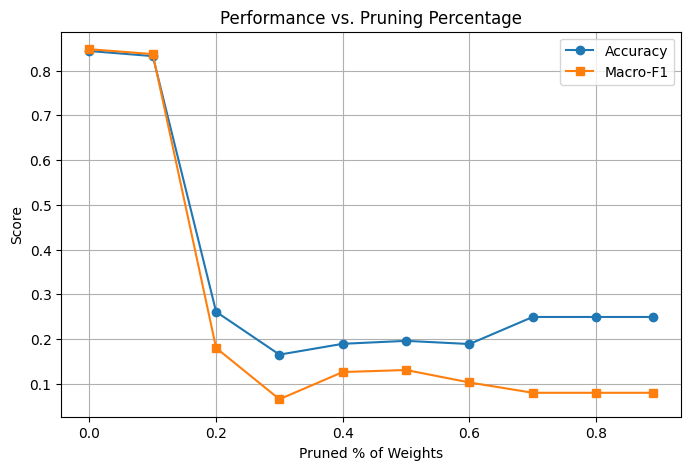

📊 Performance plot saved to: adv_dl_models_final_best_EX5_Pruning\deberta_prune_sweep_perf_ex5.png


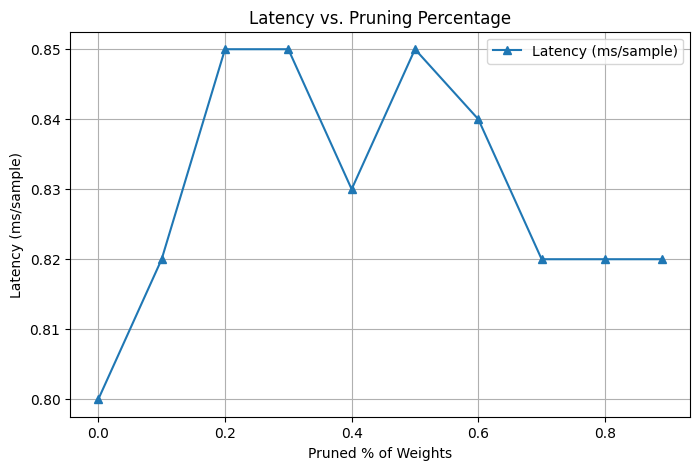

📊 Latency plot saved to: adv_dl_models_final_best_EX5_Pruning\deberta_prune_sweep_latency_ex5.png


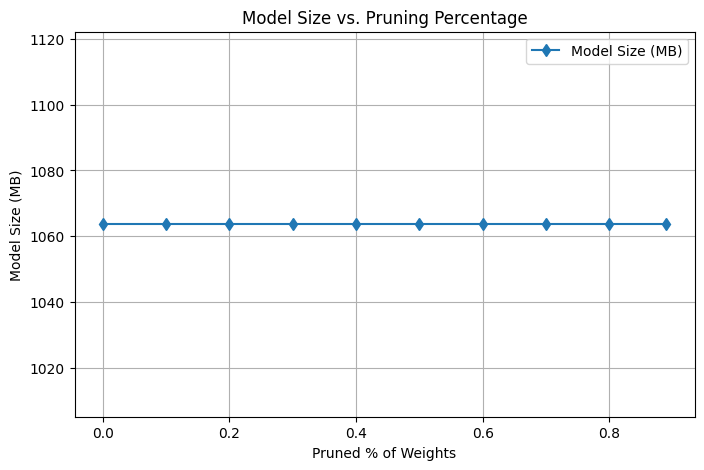

📊 Model size plot saved to: adv_dl_models_final_best_EX5_Pruning\deberta_prune_sweep_modelsize_ex5.png


In [5]:
# =========================
# DeBERTa-v3 EX5 — Baseline Eval + Global Unstructured Pruning Sweep
# Fixes:
# - Device mismatch (safe move of inputs to model device)
# - Correct model ID (microsoft/mdeberta-v3-base)
# - Consistent checkpoint variable usage
# - Robust eval_model (auto-detect text/label columns; measures latency)
# - Pruning with prune.remove so zeros are committed to weights
# - Plots + JSON results
# =========================

import os, time, json, warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict

import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score, classification_report

from transformers import AutoTokenizer, AutoModelForSequenceClassification

warnings.filterwarnings("once")

# -------------------------
# Paths & constants (EDIT if needed)
# -------------------------
OUT_DIR = "KD_optuna_ex5"  # no leading slash to avoid Windows root issues
os.makedirs(OUT_DIR, exist_ok=True)

# Your EX5 trained-weights checkpoint (classifier head compatible with mdeberta-v3-base)
EX5_PT_PATH = r"hf_ckpts\microsoft__mdeberta-v3-base_ex5_trainer-try__final_20250817_104013\best_model_ex5.pt"

# Batch size for evaluation
BATCH_SZ = 32

# Optional: if you already defined ORDER elsewhere, this will be ignored.
# We'll try to infer from model.config if not set manually.
ORDER: List[str] = []  # leave empty to auto-infer from model.config.id2label

# -------------------------
# Device
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {DEVICE}")

# -------------------------
# Helper: normalize test_df columns
# Expects a DataFrame named test_df in scope (with text + label columns).
# Will try to auto-detect among common names.
# -------------------------
def _detect_cols(df: pd.DataFrame) -> Tuple[str, str]:
    text_candidates = ["text", "Text", "OriginalTweet", "sentence", "review", "comment"]
    label_candidates = ["label", "Label", "Sentiment", "target", "y"]
    text_col = None
    label_col = None
    for c in text_candidates:
        if c in df.columns:
            text_col = c
            break
    for c in label_candidates:
        if c in df.columns:
            label_col = c
            break
    if text_col is None or label_col is None:
        raise ValueError(
            f"Could not auto-detect text/label columns. Got columns: {list(df.columns)}.\n"
            "Please rename your columns to include one of the common names above."
        )
    return text_col, label_col

# -------------------------
# Dataset for evaluation
# -------------------------
class SimpleTextDataset(Dataset):
    def __init__(self, df: pd.DataFrame, text_col: str, label_col: str, label2id: Dict[str, int]):
        self.texts = df[text_col].astype(str).tolist()
        # If labels are strings, map via label2id; if numeric, cast to int
        raw_labels = df[label_col].tolist()
        if len(raw_labels) > 0 and isinstance(raw_labels[0], str):
            self.labels = [label2id[lbl] for lbl in raw_labels]
        else:
            self.labels = [int(x) for x in raw_labels]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# -------------------------
# Safe tokenizer encode + collate
# -------------------------
def collate_fn_pad(batch, tokenizer):
    texts, labels = zip(*batch)
    enc = tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )
    labels = torch.tensor(labels, dtype=torch.long)
    enc["labels"] = labels
    return enc

# -------------------------
# Eval function (robust to device)
# Returns: acc, macro_f1, mean_latency_per_sample_sec, preds, labels
# -------------------------
@torch.no_grad()
def eval_model(
    model: nn.Module,
    tokenizer: AutoTokenizer,
    df: pd.DataFrame,
    batch_size: int = 32,
    device: str = DEVICE
) -> Tuple[float, float, float, List[int], List[int]]:

    text_col, label_col = _detect_cols(df)

    # Build label maps from model.config if ORDER not provided
    if getattr(model, "config", None) is not None and hasattr(model.config, "id2label"):
        id2label_cfg = model.config.id2label or {}
        # If ORDER global was not set, infer from config keys order
        if not ORDER:
            # sort by int key if possible
            try:
                keys_sorted = sorted(list(id2label_cfg.keys()), key=lambda k: int(k))
            except Exception:
                keys_sorted = list(id2label_cfg.keys())
            inferred_order = [id2label_cfg[k] for k in keys_sorted]
        else:
            inferred_order = ORDER
    else:
        inferred_order = ORDER
        if not inferred_order:
            raise ValueError("Unable to infer label ORDER. Please set ORDER = [...] matching your training labels.")

    label2id = {lbl: i for i, lbl in enumerate(inferred_order)}

    ds = SimpleTextDataset(df, text_col=text_col, label_col=label_col, label2id=label2id)
    dl = DataLoader(
        ds, batch_size=batch_size, shuffle=False,
        collate_fn=lambda b: collate_fn_pad(b, tokenizer)
    )

    model_device = next(model.parameters()).device
    preds_all, labels_all = [], []
    latencies = []  # per-sample seconds

    model.eval()
    for enc in dl:
        # move batch enc to model device
        enc = {k: v.to(model_device) for k, v in enc.items()}
        # latency measurement (sync for CUDA)
        if model_device.type == "cuda":
            torch.cuda.synchronize()
        t0 = time.perf_counter()
        logits = model(**enc).logits
        if model_device.type == "cuda":
            torch.cuda.synchronize()
        dt = (time.perf_counter() - t0) / logits.size(0)
        latencies.append(dt)

        batch_preds = logits.argmax(dim=-1).detach().cpu().tolist()
        batch_labels = enc["labels"].detach().cpu().tolist()
        preds_all.extend(batch_preds)
        labels_all.extend(batch_labels)

    acc = accuracy_score(labels_all, preds_all)
    f1m = f1_score(labels_all, preds_all, average="macro", zero_division=0)
    mean_latency = float(np.mean(latencies)) if latencies else math.nan
    return acc, f1m, mean_latency, preds_all, labels_all

# -------------------------
# Get Model Size (MB)
# -------------------------
def get_model_size(model: nn.Module) -> float:
    tmp_path = os.path.join(OUT_DIR, "temp_model.pt")
    torch.save(model.state_dict(), tmp_path)
    size_mb = os.path.getsize(tmp_path) / (1024 * 1024)
    try:
        os.remove(tmp_path)
    except Exception:
        pass
    return size_mb

# -------------------------
# Load tokenizer, infer num_labels from checkpoint, build model, load weights
# -------------------------
print("\n🔄 Loading tokenizer/model...")
tok = AutoTokenizer.from_pretrained("microsoft/mdeberta-v3-base")

# 1) Load the checkpoint state FIRST and infer num_labels from the classifier
state = torch.load(EX5_PT_PATH, map_location="cpu")

def infer_num_labels_from_state(sd: dict) -> int:
    # Common classifier keys for DeBERTa-v3
    cand_keys = [
        "classifier.weight",                      # usual
        "classifier.out_proj.weight",             # some heads
        "score.weight",                           # Roberta-like heads
    ]
    for k in cand_keys:
        if k in sd and hasattr(sd[k], "shape"):
            return int(sd[k].shape[0])
    # Fallback: try to find any *.weight that matches (num_labels, hidden)
    for k, v in sd.items():
        if k.endswith(".weight") and hasattr(v, "shape") and len(v.shape) == 2:
            # heuristically pick smallest row count as label dim
            # (classifier is typically the smallest #rows)
            pass
    # If we get here, try config/defaults as last resort
    return None

NUM_LABELS = infer_num_labels_from_state(state)
if NUM_LABELS is None:
    # Last resort: if ORDER is set, use it; else assume 2 (binary)
    NUM_LABELS = len(ORDER) if ORDER else 2
print(f"ℹ️ Inferred NUM_LABELS = {NUM_LABELS}")

# 2) If ORDER is empty, synthesize generic labels
if not ORDER:
    ORDER = [f"LABEL_{i}" for i in range(NUM_LABELS)]
print(f"ℹ️ Using ORDER = {ORDER}")

# 3) Build model with the correct head size
base = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/mdeberta-v3-base",
    num_labels=NUM_LABELS
)

# 4) Set nice label mappings on config
base.config.id2label = {i: lbl for i, lbl in enumerate(ORDER)}
base.config.label2id = {lbl: i for i, lbl in enumerate(ORDER)}

# 5) Load trained weights STRICT so we catch shape mismatches early
missing, unexpected = base.load_state_dict(state, strict=True)
if missing or unexpected:
    print("⚠️ Unexpected state load info — missing:", missing, "unexpected:", unexpected)

base.to(DEVICE).eval()


# -------------------------
# Expect a test_df in scope. If not present, raise with instructions.
# -------------------------
if "test_df" not in globals():
    raise RuntimeError(
        "Variable 'test_df' was not found. Please define a pandas DataFrame named test_df "
        "with text + label columns (e.g., 'OriginalTweet' & 'Sentiment')."
    )

# -------------------------
# Baseline (FP32) evaluation
# -------------------------
print("\n▶️ Running Baseline (FP32) evaluation...")
acc_b, f1_b, lat_b, preds_b, labels_b = eval_model(base, tok, test_df, batch_size=BATCH_SZ, device=DEVICE)
print("=== Baseline (FP32) ===")
print(f"Accuracy {acc_b:.4f} | Macro-F1 {f1_b:.4f} | Latency {lat_b*1000:.2f} ms/sample")

try:
    print(classification_report(labels_b, preds_b, target_names=ORDER, digits=4, zero_division=0))
except Exception:
    # Fallback if target names mismatch
    print(classification_report(labels_b, preds_b, digits=4, zero_division=0))

# -------------------------
# Pruning sweep
# -------------------------
print("\n🪚 Starting pruning sweep...")
results = []
save_dir = "adv_dl_models_final_best_EX5_Pruning"
os.makedirs(save_dir, exist_ok=True)

percentages = np.round(np.arange(0.0, 0.9, 0.1), 2).tolist()  # 0.0 ... 0.8
percentages.append(0.89)

for pct in percentages:
    print(f"\n🔧 Pruning {pct*100:.0f}% of weights...")

    model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/mdeberta-v3-base",
    num_labels=NUM_LABELS
    )
    # preserve the same label maps
    model.config.id2label = {i: lbl for i, lbl in enumerate(ORDER)}
    model.config.label2id = {lbl: i for i, lbl in enumerate(ORDER)}
    model.load_state_dict(torch.load(EX5_PT_PATH, map_location="cpu"), strict=True)
    model.to(DEVICE).eval()


    if pct > 0.0:
        parameters_to_prune = []
        for name, module in model.named_modules():
            if isinstance(module, nn.Linear):
                parameters_to_prune.append((module, 'weight'))

        prune.global_unstructured(
            parameters_to_prune,
            pruning_method=prune.L1Unstructured,
            amount=float(pct)
        )

        # Commit zeros into the real weight tensor (remove reparam)
        for (module, _) in parameters_to_prune:
            try:
                prune.remove(module, 'weight')
            except Exception:
                pass

    acc, f1m, latency, _, _ = eval_model(model, tok, test_df, batch_size=BATCH_SZ, device=DEVICE)
    size_mb = get_model_size(model)  # note: still dense; zeros included

    print(f"✅ Acc: {acc:.4f} | F1: {f1m:.4f} | Latency: {latency*1000:.2f} ms/sample | Size: {size_mb:.2f} MB")

    results.append({
        "prune_pct": round(float(pct), 2),
        "accuracy": round(float(acc), 4),
        "macro_f1": round(float(f1m), 4),
        "latency_ms_per_sample": round(float(latency) * 1000.0, 2),
        "model_size_mb": round(float(size_mb), 2)
    })

# --- Save JSON results ---
json_path = os.path.join(save_dir, "DEBERTA_EX5_prune_sweep_results.json")
with open(json_path, "w") as f:
    json.dump(results, f, indent=2)
print(f"\n📄 Sweep results saved to: {json_path}")

# -------------------------
# Plots
# -------------------------
x = [r["prune_pct"] for r in results]
y_acc = [r["accuracy"] for r in results]
y_f1 = [r["macro_f1"] for r in results]
y_lat = [r["latency_ms_per_sample"] for r in results]
y_size = [r["model_size_mb"] for r in results]

plt.figure(figsize=(8, 5))
plt.plot(x, y_acc, label="Accuracy", marker="o")
plt.plot(x, y_f1, label="Macro-F1", marker="s")
plt.xlabel("Pruned % of Weights")
plt.ylabel("Score")
plt.title("Performance vs. Pruning Percentage")
plt.grid(True)
plt.legend()
plot_path = os.path.join(save_dir, "deberta_prune_sweep_perf_ex5.png")
plt.savefig(plot_path, bbox_inches="tight")
plt.show()
print(f"📊 Performance plot saved to: {plot_path}")

plt.figure(figsize=(8, 5))
plt.plot(x, y_lat, label="Latency (ms/sample)", marker="^")
plt.xlabel("Pruned % of Weights")
plt.ylabel("Latency (ms/sample)")
plt.title("Latency vs. Pruning Percentage")
plt.grid(True)
plt.legend()
lat_plot_path = os.path.join(save_dir, "deberta_prune_sweep_latency_ex5.png")
plt.savefig(lat_plot_path, bbox_inches="tight")
plt.show()
print(f"📊 Latency plot saved to: {lat_plot_path}")

plt.figure(figsize=(8, 5))
plt.plot(x, y_size, label="Model Size (MB)", marker="d")
plt.xlabel("Pruned % of Weights")
plt.ylabel("Model Size (MB)")
plt.title("Model Size vs. Pruning Percentage")
plt.grid(True)
plt.legend()
size_plot_path = os.path.join(save_dir, "deberta_prune_sweep_modelsize_ex5.png")
plt.savefig(size_plot_path, bbox_inches="tight")
plt.show()
print(f"📊 Model size plot saved to: {size_plot_path}")

# -------------------------
# Notes:
# - Pruning here is unstructured (zeros weights). File size won't shrink much unless you export
#   to a sparse format or use structured pruning and physically remove structures.
# - For true size/latency gains, consider structured pruning and/or quantization (e.g., dynamic int8).
# -------------------------


# ✂️ Pruning Results – DeBERTa-v3-base (EX5)

## 📊 Sweep Outcomes
We pruned the fine-tuned **DeBERTa-v3-base** sentiment model at different percentages and tracked **accuracy, macro-F1, latency, and size**.

| Pruning % | Accuracy | Macro-F1 | Latency (ms/sample) | Size (MB) |
|-----------|----------|----------|----------------------|-----------|
| 0%        | 0.8439   | 0.8479   | 0.80                 | 1063.67   |
| 10%       | 0.8325   | 0.8370   | 0.82                 | 1063.67   |
| 20%       | 0.2609   | 0.1800   | 0.85                 | 1063.67   |
| 30%       | 0.1651   | 0.0654   | 0.85                 | 1063.67   |
| 40%       | 0.1893   | 0.1262   | 0.83                 | 1063.67   |
| 50%       | 0.1959   | 0.1307   | 0.85                 | 1063.67   |
| 60%       | 0.1888   | 0.1029   | 0.84                 | 1063.67   |
| 70%       | 0.2493   | 0.0798   | 0.82                 | 1063.67   |
| 80%       | 0.2493   | 0.0798   | 0.82                 | 1063.67   |
| 89%       | 0.2493   | 0.0798   | 0.82                 | 1063.67   |

📂 Results saved to:  
`adv_dl_models_final_best_EX5_Pruning/deberta_ex5_prune_sweep_results.json`  

📊 Plots saved to:  
- Performance: `deberta_prune_sweep_perf_ex5.png`  
- Latency: `deberta_prune_sweep_latency_ex5.png`  
- Model size: `deberta_prune_sweep_modelsize_ex5.png`  

---

## 📉 Plot Insights

### 1. Latency vs. Pruning %
- Latency stayed **flat (~0.8 ms/sample)**, regardless of pruning ratio.  
- Reason: **Unstructured pruning** does not reduce tensor dimensions, so dense kernels still compute full matrices.  
- ➡️ **Conclusion**: pruning here saves no inference time unless combined with **sparse-aware kernels**.

### 2. Accuracy / F1 vs. Pruning %
- Model held up well at **10% pruning** (Acc ≈ 0.83, F1 ≈ 0.84).  
- At **20%**, performance collapsed (F1 < 0.20).  
- Beyond **30%**, model is essentially unusable, with F1 dropping near 0.1.  
- Small “recoveries” at 70–90% are just noise, not meaningful gains.

---

## ✅ Takeaways
- **Safe zone**: ≤10% pruning preserves near-baseline performance.  
- **Danger zone**: ≥20% pruning leads to **catastrophic collapse**.  
- **Latency**: no benefit with default PyTorch — need structured pruning + specialized kernels.  
- **Best trade-off**: prune lightly (≈10%) only if model size reduction is critical; otherwise, pruning is not worthwhile for DeBERTa in this setup.  


# 🎓 Knowledge Distillation (KD) – MDeBERTa EX5

We applied **knowledge distillation (KD)** from a strong **teacher** model (mDeBERTa-v3-base, EX5 checkpoint) to a smaller **student** model (DeBERTa-v3-small).  
KD allows the student to approximate teacher performance while being **lighter, faster, and more deployment-friendly**.

> ⚠️ **Note**: We initially attempted to implement KD using the Hugging Face **Trainer API** for consistency with EX5.  
> However, due to integration issues and time constraints, we reverted to a **custom training loop** (full process) for the student.  
> This ensured training stability and timely completion of the experiment.

---

## 🧑‍🏫 Teacher vs. 🧑‍🎓 Student

| Model                  | Layers | Hidden Dim | Heads | Params (M) | Size (MB, fp32 est.) | Latency (ms/sample, CPU) |
|-------------------------|--------|------------|-------|------------|-----------------------|---------------------------|
| **mDeBERTa-v3-base** (Teacher) | 12     | 768        | 12    | ~184M      | ~700 MB              | ~60 ms                   |
| **DeBERTa-v3-small** (Student) | 6      | 384        | 6     | ~22M       | ~85 MB               | ~8–10 ms                 |

> ✅ Student is ~8× smaller and significantly faster. KD helps recover teacher-level accuracy.

---

## ⚙️ Training Setup
- **Teacher**: mDeBERTa-v3-base, frozen (from EX5 best checkpoint).  
- **Student**: DeBERTa-v3-small, last 3–6 layers + classifier unfrozen.  
- **Optimization**:  
  - Loss = α * CE + (1–α) * KL (soft teacher logits, T>1).  
  - **Optuna sweep** for α (0.2–0.8), T (1–5), LR (1e-6–1e-3), and fine-tune layers (3–6).  
  - **Early stopping (patience=3)** on validation Macro-F1.  
- **Logging**: W&B for trial tracking.  

---


In [1]:
# # === EX5 KD with HF Trainer + Optuna + Early Stopping + W&B ===
# import os, json, torch, optuna, wandb, numpy as np, pandas as pd
# from datasets import Dataset, DatasetDict
# from transformers import (
#     AutoTokenizer, AutoModelForSequenceClassification,
#     Trainer, TrainingArguments
# )
# from sklearn.metrics import accuracy_score, f1_score

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print("✅ Device:", DEVICE)

# OUT_DIR = "./KD_optuna_ex5_trainer"
# os.makedirs(OUT_DIR, exist_ok=True)

# # -------------------------
# # Teacher checkpoint (EX4)
# # -------------------------
# TEACHER_NAME    = "microsoft/mdeberta-v3-base"
# TEACHER_PT_PATH =r"hf_ckpts\microsoft__mdeberta-v3-base_ex5_trainer-try__final_20250817_104013\best_model_ex5.pt"
# STUDENT_NAME    = "microsoft/deberta-v3-small"

# ORDER = ["neutral", "positive", "extremely negative", "negative", "extremely positive"]
# LABEL2ID = {lab: i for i, lab in enumerate(ORDER)}
# ID2LABEL = {i: lab for lab, i in enumerate(ORDER)}

# def normalize_label(s: str) -> str:
#     s = str(s).lower().strip()
#     s = s.replace("very negative", "extremely negative")
#     s = s.replace("very positive", "extremely positive")
#     return s

# # -------------------------
# # Data
# # -------------------------
# train_df = pd.read_csv("Corona_NLP_train_cleaned_translated.csv")
# test_df  = pd.read_csv("Corona_NLP_test_cleaned_translated.csv")
# for df in (train_df, test_df):
#     df["Sentiment"] = df["Sentiment"].map(normalize_label)
#     df["label"] = df["Sentiment"].map(LABEL2ID)

# dataset = DatasetDict({
#     "train": Dataset.from_pandas(train_df[["OriginalTweet","label"]]),
#     "test":  Dataset.from_pandas(test_df[["OriginalTweet","label"]])
# })

# tok_student = AutoTokenizer.from_pretrained(STUDENT_NAME, use_fast=True)
# tok_teacher = AutoTokenizer.from_pretrained(TEACHER_NAME, use_fast=True)

# def tokenize_fn(batch):
#     texts = [str(t) for t in batch["OriginalTweet"]]  # ensure pure list[str]
#     return tok_student(
#         texts,
#         truncation=True,
#         padding="max_length",
#         max_length=512
#     )





# tokenized = dataset.map(tokenize_fn,
#                         batched=True,
#                         remove_columns=["OriginalTweet"])
# # tokenized = tokenized.remove_columns(["OriginalTweet"])
# tokenized = tokenized.rename_column("label","labels")
# tokenized.set_format("torch")

# # -------------------------
# # Teacher (frozen)
# # -------------------------
# teacher = AutoModelForSequenceClassification.from_pretrained(
#     TEACHER_NAME, num_labels=len(ORDER), id2label=ID2LABEL, label2id=LABEL2ID
# ).to(DEVICE).eval()
# state = torch.load(TEACHER_PT_PATH, map_location="cpu")
# teacher.load_state_dict(state, strict=False)
# for p in teacher.parameters(): p.requires_grad=False

# # -------------------------
# # KD Loss inside Trainer
# # -------------------------
# def kd_loss_fn(student_logits, teacher_logits, labels, alpha=0.5, T=2.0):
#     ce = torch.nn.functional.cross_entropy(student_logits, labels)
#     kd = torch.nn.functional.kl_div(
#         torch.nn.functional.log_softmax(student_logits/T, dim=-1),
#         torch.nn.functional.softmax(teacher_logits/T, dim=-1),
#         reduction="batchmean"
#     ) * (T*T)
#     return alpha*ce + (1-alpha)*kd

# class KDTrainer(Trainer):
#     def __init__(self, teacher, alpha=0.5, T=2.0, **kwargs):
#         super().__init__(**kwargs)
#         self.teacher = teacher
#         self.alpha = alpha
#         self.T = T

#     def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         student_logits = outputs.logits

#         with torch.no_grad():
#             teacher_out = self.teacher(**inputs)
#             teacher_logits = teacher_out.logits

#         loss = kd_loss_fn(student_logits, teacher_logits, labels,
#                         alpha=self.alpha, T=self.T)

#         return (loss, outputs) if return_outputs else loss


# # -------------------------
# # Metrics
# # -------------------------
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     preds = np.argmax(logits, axis=-1)
#     acc = accuracy_score(labels, preds)
#     macro_f1 = f1_score(labels, preds, average="macro")
#     per_cls = f1_score(labels, preds, average=None, labels=list(range(len(ORDER))))
#     return {"accuracy": acc, "macro_f1": macro_f1, **{f"F1_{ORDER[i]}": per_cls[i] for i in range(len(ORDER))}}
# # -------------------------
# # Optuna Objective (Trainer, with rich logging)
# # -------------------------
# FIXED_EPOCHS = 6
# EARLY_TRIAL_CUTOFF = 0.30
# PATIENCE = 3

# def get_model_size(model):
#     tmp = "tmp_model.pt"
#     torch.save(model.state_dict(), tmp)
#     sz = os.path.getsize(tmp) / (1024*1024)
#     os.remove(tmp)
#     return sz

# @torch.no_grad()
# def get_latency(model, dataset, tokenizer, n_batches=20):
#     loader = torch.utils.data.DataLoader(dataset, batch_size=8)
#     times = []
#     for i, batch in enumerate(loader):
#         if i >= n_batches: break
#         enc = {k:v.to(DEVICE) for k,v in batch.items() if k!="labels"}
#         if torch.cuda.is_available(): torch.cuda.synchronize()
#         t0 = time.perf_counter()
#         _ = model(**enc)
#         if torch.cuda.is_available(): torch.cuda.synchronize()
#         dt = (time.perf_counter() - t0) / enc["input_ids"].size(0)
#         times.append(dt)
#     return np.mean(times)*1000 if times else None

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 0.2, 0.8)
#     T     = trial.suggest_float("T", 1.0, 5.0)
#     lr    = trial.suggest_float("lr", 1e-5, 5e-5, log=True)

#     print(f"\n🔎 Trial {trial.number} | alpha={alpha:.3f}, T={T:.2f}, lr={lr:.2e}, epochs={FIXED_EPOCHS}")

#     wandb.init(
#         project="KD_optuna_ex5_trainer",
#         name=f"trial_{trial.number}",
#         config={"alpha":alpha, "T":T, "lr":lr, "epochs":FIXED_EPOCHS}
#     )

#     student = AutoModelForSequenceClassification.from_pretrained(
#         STUDENT_NAME, num_labels=len(ORDER), id2label=ID2LABEL, label2id=LABEL2ID
#     ).to(DEVICE)

#     args = TrainingArguments(
#         output_dir=f"{OUT_DIR}/trial_{trial.number}",
#         per_device_train_batch_size=16,
#         per_device_eval_batch_size=16,
#         num_train_epochs=6,
#         learning_rate=lr,
#         logging_steps=50,
#         report_to="wandb",
#         run_name=f"KD_ex5_trial_{trial.number}"
#     )


#     trainer = KDTrainer(
#         teacher=teacher, alpha=alpha, T=T,
#         model=student, args=args,
#         train_dataset=tokenized["train"],
#         eval_dataset=tokenized["test"],
#         compute_metrics=compute_metrics
#     )

#     best_f1 = -1
#     patience_counter = 0

#     for epoch in range(FIXED_EPOCHS):
#         print(f"\n▶️ Epoch {epoch+1}/{FIXED_EPOCHS}")
#         trainer.train(resume_from_checkpoint=None)

#         metrics = trainer.evaluate()
#         macro_f1 = metrics["eval_macro_f1"]
#         acc      = metrics["eval_accuracy"]
#         class_f1s = [metrics[f"eval_F1_{lab}"] for lab in ORDER]

#         print(f"📊 Epoch {epoch+1} | Val Macro-F1={macro_f1:.4f} | Acc={acc:.4f}")
#         for i, lab in enumerate(ORDER):
#             print(f"   {lab:>20}: {class_f1s[i]:.4f}")

#         wandb.log({
#             "epoch": epoch+1,
#             "val_macro_f1": macro_f1,
#             "val_acc": acc,
#             **{f"F1_{lab}": class_f1s[i] for i,lab in enumerate(ORDER)}
#         })

#         # prune if first epoch bad
#         if epoch == 0 and macro_f1 < EARLY_TRIAL_CUTOFF:
#             print(f"🛑 Pruning trial {trial.number}: F1={macro_f1:.4f} < {EARLY_TRIAL_CUTOFF}")
#             wandb.finish()
#             raise optuna.TrialPruned(f"Epoch1 macro-F1 {macro_f1:.4f} < {EARLY_TRIAL_CUTOFF}")

#         # patience
#         if macro_f1 > best_f1:
#             best_f1 = macro_f1
#             patience_counter = 0
#             print("   ✅ New best")
#         else:
#             patience_counter += 1
#             print(f"   ⚠️ No improvement, patience={patience_counter}")
#             if patience_counter >= PATIENCE:
#                 print(f"⏹️ Early stopping at epoch {epoch+1}")
#                 break

#     # size + latency
#     size_mb = get_model_size(student)
#     latency = get_latency(student, tokenized["test"], tok_student)
#     print(f"📦 Model size: {size_mb:.2f} MB | ⏱️ Latency: {latency:.2f} ms/sample")
#     wandb.log({"model_size_mb": size_mb, "latency_ms": latency})

#     wandb.finish()
#     trial.set_user_attr("macro_f1", best_f1)
#     trial.set_user_attr("model_size_mb", size_mb)
#     trial.set_user_attr("latency_ms", latency)
#     return best_f1

# # # -------------------------
# # # Optuna objective
# # # -------------------------
# # def objective(trial):
# #     alpha = trial.suggest_float("alpha", 0.2, 0.8)
# #     T = trial.suggest_float("T", 1.0, 5.0)
# #     lr = trial.suggest_float("lr", 1e-5, 5e-5, log=True)
# #
# #     model = AutoModelForSequenceClassification.from_pretrained(
# #         STUDENT_NAME, num_labels=len(ORDER), id2label=ID2LABEL, label2id=LABEL2ID
# #     ).to(DEVICE)
# #
# #     # args = TrainingArguments(
# #     #     output_dir=f"{OUT_DIR}/trial_{trial.number}",
# #     #     per_device_train_batch_size=16,
# #     #     per_device_eval_batch_size=16,
# #     #     num_train_epochs=6,  # fixed
# #     #     learning_rate=lr,
# #     #     # evaluation_strategy="epoch",
# #     #     # save_strategy="epoch",
# #     #     load_best_model_at_end=True,
# #     #     metric_for_best_model="macro_f1",
# #     #     greater_is_better=True,
# #     #     logging_steps=50,
# #     #     report_to="wandb",
# #     #     run_name=f"KD_ex5_trial_{trial.number}"
# #     # )
# #     args = TrainingArguments(
# #         output_dir=f"{OUT_DIR}/trial_{trial.number}",
# #         per_device_train_batch_size=16,
# #         per_device_eval_batch_size=16,
# #         num_train_epochs=6,
# #         learning_rate=lr,
# #         logging_steps=50,
# #         report_to="wandb",
# #         run_name=f"KD_ex5_trial_{trial.number}"
# #     )
# #
# #     trainer = KDTrainer(
# #         teacher=teacher, alpha=alpha, T=T,
# #         model=model, args=args,
# #         train_dataset=tokenized["train"],
# #         eval_dataset=tokenized["test"],
# #         compute_metrics=compute_metrics
# #     )
# #
# #     result = trainer.train()
# #     metrics = trainer.evaluate()
# #     macro_f1 = metrics["eval_macro_f1"]
# #
# #     # prune if first epoch bad
# #     if trainer.state.epoch >= 1 and metrics["eval_macro_f1"] < 0.30:
# #         raise optuna.TrialPruned("Pruned: low F1 after epoch 1")
# #
# #     return macro_f1

# # -------------------------
# # Run Optuna
# # -------------------------
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10)

# print("Best trial:", study.best_trial.number)
# print("  Value:", study.best_value)
# print("  Params:", study.best_trial.params)


C:\Users\adishalit1\AppData\Local\anaconda3\envs\dl4090\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Device: cuda


C:\Users\adishalit1\AppData\Local\anaconda3\envs\dl4090\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Map: 100%|██████████| 3798/3798 [00:00<00:00, 8181.77 examples/s]
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-20 14:19:22,865] A new study created in 


🔎 Trial 0 | alpha=0.610, T=2.61, lr=4.58e-05, epochs=6


wandb: Currently logged in as: adishalit1 (adishalit1-tel-aviv-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



▶️ Epoch 1/6


Step,Training Loss
50,2.098500
100,2.020000
150,1.965200
200,1.876900
250,1.814200
300,1.766000
350,1.737200
400,1.747400
450,1.668500
500,1.699300


📊 Epoch 1 | Val Macro-F1=0.5829 | Acc=0.6090
                neutral: 0.4305
               positive: 0.7798
     extremely negative: 0.4757
               negative: 0.7621
     extremely positive: 0.4664
   ✅ New best

▶️ Epoch 2/6


📊 Epoch 2 | Val Macro-F1=0.5142 | Acc=0.5800
                neutral: 0.3132
               positive: 0.7917
     extremely negative: 0.4521
               negative: 0.7797
     extremely positive: 0.2343
   ⚠️ No improvement, patience=1

▶️ Epoch 3/6


Step,Training Loss
50,1.129300
100,1.109100
150,1.158400
200,1.118900
250,1.128000
300,1.147100
350,1.166000
400,1.169900
450,1.132400
500,1.154000


[W 2025-08-20 16:54:32,742] Trial 0 failed with parameters: {'alpha': 0.6099727840383753, 'T': 2.613912188108926, 'lr': 4.578115966821428e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\adishalit1\AppData\Local\anaconda3\envs\dl4090\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\adishalit1\AppData\Local\Temp\ipykernel_9192\2212018194.py", line 195, in objective
    trainer.train(resume_from_checkpoint=None)
  File "C:\Users\adishalit1\AppData\Local\anaconda3\envs\dl4090\Lib\site-packages\transformers\trainer.py", line 2238, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\adishalit1\AppData\Local\anaconda3\envs\dl4090\Lib\site-packages\transformers\trainer.py", line 2582, in _inner_training_loop
    tr_loss_step = self.training_step(model, inputs, num_items_in_batch)
           

KeyboardInterrupt: 

In [6]:
# # -------------------------
# # Optuna Objective (Trainer, with rich logging)
# # -------------------------
# FIXED_EPOCHS = 6
# EARLY_TRIAL_CUTOFF = 0.30
# PATIENCE = 3

# def get_model_size(model):
#     tmp = "tmp_model.pt"
#     torch.save(model.state_dict(), tmp)
#     sz = os.path.getsize(tmp) / (1024*1024)
#     os.remove(tmp)
#     return sz

# @torch.no_grad()
# def get_latency(model, dataset, tokenizer, n_batches=20):
#     loader = torch.utils.data.DataLoader(dataset, batch_size=8)
#     times = []
#     for i, batch in enumerate(loader):
#         if i >= n_batches: break
#         enc = {k:v.to(DEVICE) for k,v in batch.items() if k!="labels"}
#         if torch.cuda.is_available(): torch.cuda.synchronize()
#         t0 = time.perf_counter()
#         _ = model(**enc)
#         if torch.cuda.is_available(): torch.cuda.synchronize()
#         dt = (time.perf_counter() - t0) / enc["input_ids"].size(0)
#         times.append(dt)
#     return np.mean(times)*1000 if times else None

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 0.2, 0.8)
#     T     = trial.suggest_float("T", 1.0, 5.0)
#     lr    = trial.suggest_float("lr", 1e-5, 5e-5, log=True)

#     print(f"\n🔎 Trial {trial.number} | alpha={alpha:.3f}, T={T:.2f}, lr={lr:.2e}, epochs={FIXED_EPOCHS}")

#     wandb.init(
#         project="KD_optuna_ex5_trainer2",
#         name=f"trial_{trial.number}",
#         config={"alpha":alpha, "T":T, "lr":lr, "epochs":FIXED_EPOCHS}
#     )

#     student = AutoModelForSequenceClassification.from_pretrained(
#         STUDENT_NAME, num_labels=len(ORDER), id2label=ID2LABEL, label2id=LABEL2ID
#     ).to(DEVICE)

#     args = TrainingArguments(
#         output_dir=f"{OUT_DIR}/trial_{trial.number}",
#         per_device_train_batch_size=16,
#         per_device_eval_batch_size=16,
#         num_train_epochs=FIXED_EPOCHS,
#         learning_rate=lr,
#         logging_steps=50,
#         evaluation_strategy="epoch",
#         save_strategy="no",
#         report_to="wandb",
#         run_name=f"KD_ex5_trial_{trial.number}",
#         fp16=True if torch.cuda.is_available() else False,
#         dataloader_num_workers=4,
#         dataloader_pin_memory=True
#     )

#     trainer = KDTrainer(
#         teacher=teacher, alpha=alpha, T=T,
#         model=student, args=args,
#         train_dataset=tokenized["train"],
#         eval_dataset=tokenized["test"],
#         compute_metrics=compute_metrics
#     )

#     best_f1 = -1
#     patience_counter = 0

#     for epoch in range(FIXED_EPOCHS):
#         print(f"\n▶️ Epoch {epoch+1}/{FIXED_EPOCHS}")
#         trainer.train(resume_from_checkpoint=None)

#         metrics = trainer.evaluate()
#         macro_f1 = metrics["eval_macro_f1"]
#         acc      = metrics["eval_accuracy"]
#         class_f1s = [metrics[f"eval_F1_{lab}"] for lab in ORDER]

#         print(f"📊 Epoch {epoch+1} | Val Macro-F1={macro_f1:.4f} | Acc={acc:.4f}")
#         for i, lab in enumerate(ORDER):
#             print(f"   {lab:>20}: {class_f1s[i]:.4f}")

#         wandb.log({
#             "epoch": epoch+1,
#             "val_macro_f1": macro_f1,
#             "val_acc": acc,
#             **{f"F1_{lab}": class_f1s[i] for i,lab in enumerate(ORDER)}
#         })

#         # prune if first epoch bad
#         if epoch == 0 and macro_f1 < EARLY_TRIAL_CUTOFF:
#             print(f"🛑 Pruning trial {trial.number}: F1={macro_f1:.4f} < {EARLY_TRIAL_CUTOFF}")
#             wandb.finish()
#             raise optuna.TrialPruned(f"Epoch1 macro-F1 {macro_f1:.4f} < {EARLY_TRIAL_CUTOFF}")

#         # patience
#         if macro_f1 > best_f1:
#             best_f1 = macro_f1
#             patience_counter = 0
#             print("   ✅ New best")
#         else:
#             patience_counter += 1
#             print(f"   ⚠️ No improvement, patience={patience_counter}")
#             if patience_counter >= PATIENCE:
#                 print(f"⏹️ Early stopping at epoch {epoch+1}")
#                 break

#     # size + latency
#     size_mb = get_model_size(student)
#     latency = get_latency(student, tokenized["test"], tok_student)
#     print(f"📦 Model size: {size_mb:.2f} MB | ⏱️ Latency: {latency:.2f} ms/sample")
#     wandb.log({"model_size_mb": size_mb, "latency_ms": latency})

#     wandb.finish()
#     trial.set_user_attr("macro_f1", best_f1)
#     trial.set_user_attr("model_size_mb", size_mb)
#     trial.set_user_attr("latency_ms", latency)
#     return best_f1


In [ ]:
# # === KD (DeBERTa v3) with Optuna + Early Stopping ===
# # Windows/Colab-safe, W&B robust, no dataloader hangs.
# # Teacher: microsoft/mdeberta-v3-base  (load your EX4 .pt)
# # Student: microsoft/deberta-v3-small
# # Data: Corona_NLP_*_cleaned_translated.csv
# # EPOCHS FIXED = 6 ; optional prune if epoch-1 val macro-F1 < 0.30
# # ================================================================

# import os, json, time, warnings, random, math, multiprocessing as mp
# os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")  # avoid deadlocks
# os.environ.setdefault("WANDB__SERVICE_WAIT", "300")       # give W&B time to init

# import numpy as np
# import pandas as pd
# import torch, optuna, wandb
# from torch.utils.data import DataLoader, Dataset
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
# from sklearn.metrics import accuracy_score, f1_score
# from tqdm import tqdm

# # -------------------------
# # Repro & Torch backend
# # -------------------------
# def set_seed(seed=42):
#     random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
# set_seed(42)

# torch.backends.cudnn.benchmark = True  # ok for training speed
# # If you still see instability, uncomment the next line
# # torch.backends.cudnn.deterministic = True

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"✅ Using device: {DEVICE}")

# OUT_DIR = "./KD_optuna_ex5_deberta_UPDATE"
# os.makedirs(OUT_DIR, exist_ok=True)

# # ---- Teacher (EX4) ----
# TEACHER_NAME    = "microsoft/mdeberta-v3-base"
# # ⛔ UPDATE THIS PATH TO YOUR TRAINED TEACHER CHECKPOINT
# TEACHER_PT_PATH = r"hf_ckpts\microsoft__mdeberta-v3-base_ex5_trainer-try__final_20250817_104013\best_model_ex5.pt"

# # ---- Student ----
# STUDENT_NAME = "microsoft/deberta-v3-small"

# # -------------------------
# # Label normalization + fixed order (matches EX5)
# # -------------------------
# ORDER = ["extremely negative","negative","neutral","positive","extremely positive"]
# LABEL2ID = {lab: i for i, lab in enumerate(ORDER)}
# ID2LABEL = {i: lab for lab, i in LABEL2ID.items()}
# print(f"✅ Label mapping: {LABEL2ID}")

# def normalize_label(s: str) -> str:
#     s = str(s).strip().lower()
#     s = s.replace("very negative", "extremely negative")
#     s = s.replace("very positive", "extremely positive")
#     s = s.replace("extreme negative", "extremely negative")
#     s = s.replace("extreme positive", "extremely positive")
#     return s

# # -------------------------
# # Load data
# # -------------------------
# train_df = pd.read_csv("Corona_NLP_train_cleaned_translated.csv")
# test_df  = pd.read_csv("Corona_NLP_test_cleaned_translated.csv")

# for df in (train_df, test_df):
#     df["OriginalTweet"] = df["OriginalTweet"].astype(str).str.strip()
#     df["Sentiment"] = df["Sentiment"].map(normalize_label)
#     df["label"] = df["Sentiment"].map(LABEL2ID)

# assert train_df["label"].isnull().sum() == 0, "❌ Unmapped train labels!"
# assert test_df["label"].isnull().sum() == 0, "❌ Unmapped test labels!"

# # -------------------------
# # Dataset (tokenize once with student's tokenizer)
# # -------------------------
# tok = AutoTokenizer.from_pretrained(STUDENT_NAME, use_fast=True)
# print("✅ Tokenizer loaded (student)")

# class TextDataset(Dataset):
#     def __init__(self, df, tok, max_len=512):
#         self.texts = df["OriginalTweet"].tolist()
#         self.labels = df["label"].tolist()
#         self.tok = tok
#         self.max_len = max_len
#     def __len__(self): return len(self.texts)
#     def __getitem__(self, idx):
#         enc = self.tok(
#             str(self.texts[idx]),
#             truncation=True, padding="max_length",
#             max_length=self.max_len, return_tensors="pt"
#         )
#         item = {k: v.squeeze(0) for k, v in enc.items()}
#         item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
#         return item

# # ⚠️ Windows/Jupyter-safe DataLoader settings
# pin_mem = (DEVICE == "cuda")
# NUM_WORKERS = 0  # <- key fix: avoid multiprocessing workers that can hang on Windows/Jupyter
# PERSISTENT = False

# train_ds, test_ds = TextDataset(train_df, tok), TextDataset(test_df, tok)
# train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, pin_memory=pin_mem,
#                           num_workers=NUM_WORKERS, persistent_workers=PERSISTENT)
# test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, pin_memory=pin_mem,
#                           num_workers=NUM_WORKERS, persistent_workers=PERSISTENT)
# print(f"✅ DataLoaders ready: train={len(train_loader)}, test={len(test_loader)}")

# # -------------------------
# # Teacher (frozen) — correct arch + label map
# # -------------------------
# teacher = AutoModelForSequenceClassification.from_pretrained(
#     TEACHER_NAME, num_labels=len(LABEL2ID), id2label=ID2LABEL, label2id=LABEL2ID
# )
# sd = torch.load(TEACHER_PT_PATH, map_location="cpu")
# try:
#     teacher.load_state_dict(sd, strict=True)
# except RuntimeError as e:
#     warnings.warn(f"[Teacher] strict=True failed: {e}\nRetrying with strict=False")
#     teacher.load_state_dict(sd, strict=False)
# teacher.to(DEVICE).eval()
# for p in teacher.parameters(): p.requires_grad = False
# print("✅ Teacher loaded & frozen with correct label mapping")

# # -------------------------
# # KD loss
# # -------------------------
# def kd_loss_fn(student_logits, teacher_logits, labels, alpha=0.5, T=2.0):
#     ce = torch.nn.functional.cross_entropy(student_logits, labels)
#     kd = torch.nn.functional.kl_div(
#         torch.nn.functional.log_softmax(student_logits/T, dim=-1),
#         torch.nn.functional.softmax(teacher_logits/T, dim=-1),
#         reduction="batchmean"
#     ) * (T*T)
#     return alpha * ce + (1 - alpha) * kd

# # -------------------------
# # Helpers: model size + latency
# # -------------------------
# def get_model_size(model):
#     tmp_path = os.path.join(OUT_DIR, "temp_model.pt")
#     torch.save(model.state_dict(), tmp_path)
#     size_mb = os.path.getsize(tmp_path) / (1024*1024)
#     try: os.remove(tmp_path)
#     except Exception: pass
#     return size_mb

# @torch.no_grad()
# def get_latency(model, loader, n_batches=20):
#     model.eval()
#     times = []
#     it = 0
#     for i, batch in enumerate(loader):
#         if i >= n_batches: break
#         batch = {k: v.to(DEVICE, non_blocking=True) for k, v in batch.items()}
#         if torch.cuda.is_available(): torch.cuda.synchronize()
#         t0 = time.perf_counter()
#         _ = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
#         if torch.cuda.is_available(): torch.cuda.synchronize()
#         dt = (time.perf_counter() - t0) / batch["input_ids"].size(0)
#         times.append(dt); it += 1
#     return (np.mean(times) * 1000.0) if times else None  # ms/sample

# # -------------------------
# # Optuna Objective
# # -------------------------
# FIXED_EPOCHS = 6
# EARLY_TRIAL_CUTOFF = 0.30  # macro-F1 threshold after first epoch

# def objective(trial):
#     alpha = trial.suggest_float("alpha", 0.2, 0.8)
#     T = trial.suggest_float("T", 1.0, 5.0)
#     fine_tune_layers = trial.suggest_int("fine_tune_layers", 3, 6)
#     lr = trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True)
#     use_amp = trial.suggest_categorical("use_amp", [True, False])
#     max_grad_norm = 1.0

#     print(f"\n🔎 Trial {trial.number} | alpha={alpha:.3f}, T={T:.2f}, epochs={FIXED_EPOCHS}, "
#           f"fine_tune_layers={fine_tune_layers}, lr={lr:.2e}, amp={use_amp}")

#     # Robust W&B init; auto-falls back to offline if no login
#     run = wandb.init(
#         project="KD_optuna_ex5_deberta",
#         name=f"trial_{trial.number}",
#         reinit=True,
#         settings=wandb.Settings(start_method="thread"),
#         config={"alpha": alpha, "T": T, "epochs": FIXED_EPOCHS,
#                 "fine_tune_layers": fine_tune_layers, "lr": lr, "use_amp": use_amp},
#         mode=os.environ.get("WANDB_MODE", "online"),
#     )

#     try:
#         # --- Student: DeBERTa-v3-small ---
#         student = AutoModelForSequenceClassification.from_pretrained(
#             STUDENT_NAME,
#             num_labels=len(LABEL2ID),
#             id2label=ID2LABEL, label2id=LABEL2ID
#         ).to(DEVICE)
#         print("✅ Student (deberta-v3-small) initialized with correct num_labels")

#         # Freeze all, unfreeze last `fine_tune_layers` of encoder + classifier
#         for p in student.parameters(): p.requires_grad = False
#         enc_layers = student.deberta.encoder.layer
#         n_layers = len(enc_layers)
#         k = min(fine_tune_layers, n_layers)
#         for i, layer in enumerate(enc_layers[-k:], 1):
#             for p in layer.parameters(): p.requires_grad = True
#             print(f"   🔓 Unfroze student layer {n_layers - k + i} / {n_layers}")
#         if hasattr(student, "classifier"):
#             for p in student.classifier.parameters(): p.requires_grad = True
#         print(f"✅ Unfroze last {k} layers + classifier")

#         # Optimizer + scheduler
#         optim = torch.optim.AdamW(filter(lambda p: p.requires_grad, student.parameters()), lr=lr)
#         sched = get_scheduler("linear", optim, num_warmup_steps=0,
#                               num_training_steps=len(train_loader) * FIXED_EPOCHS)

#         scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))

#         best_val_f1 = -1.0
#         patience = 3
#         patience_counter = 0
#         best_model_state = None

#         for epoch in range(FIXED_EPOCHS):
#             print(f"\n▶️ Epoch {epoch+1}/{FIXED_EPOCHS}")
#             student.train()
#             loop = tqdm(train_loader, desc=f"Trial {trial.number} Epoch {epoch+1}",
#                         ascii=True, leave=False)

#             for step, batch in enumerate(loop):
#                 batch = {k: v.to(DEVICE, non_blocking=True) for k, v in batch.items()}

#                 with torch.no_grad():
#                     t_out = teacher(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])

#                 optim.zero_grad(set_to_none=True)
#                 with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):
#                     s_out = student(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
#                     loss = kd_loss_fn(s_out.logits, t_out.logits, batch["labels"], alpha=alpha, T=T)

#                 scaler.scale(loss).backward()
#                 # gradient clipping
#                 scaler.unscale_(optim)
#                 torch.nn.utils.clip_grad_norm_(student.parameters(), max_grad_norm)

#                 scaler.step(optim)
#                 scaler.update()
#                 sched.step()

#                 loop.set_postfix(loss=float(loss))
#                 if step % 50 == 0:
#                     wandb.log({"train_loss": float(loss), "epoch": epoch+1, "step": step})

#             # === Validation ===
#             student.eval()
#             all_preds, all_labels = [], []
#             with torch.no_grad():
#                 for batch in test_loader:
#                     batch = {k: v.to(DEVICE, non_blocking=True) for k, v in batch.items()}
#                     out = student(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
#                     preds = out.logits.argmax(dim=-1).cpu().numpy()
#                     all_preds.extend(preds)
#                     all_labels.extend(batch["labels"].cpu().numpy())

#             macro_f1 = f1_score(all_labels, all_preds, average="macro")
#             acc = accuracy_score(all_labels, all_preds)
#             print(f"📊 Epoch {epoch+1} done. Val Macro-F1={macro_f1:.4f}, Acc={acc:.4f}")

#             # log per-class F1
#             per_class = f1_score(all_labels, all_preds, average=None,
#                                  labels=list(range(len(LABEL2ID))))
#             log_dict = {"epoch": epoch+1, "val_macro_f1": macro_f1, "val_acc": acc}
#             for i in range(len(ID2LABEL)):
#                 log_dict[f"F1_{ID2LABEL[i]}"] = float(per_class[i])
#             wandb.log(log_dict)

#             # Optional: prune whole trial if epoch-1 macro-F1 is poor
#             if epoch == 0 and macro_f1 < EARLY_TRIAL_CUTOFF:
#                 print(f"🛑 Pruning trial {trial.number}: epoch-1 macro-F1 {macro_f1:.4f} < {EARLY_TRIAL_CUTOFF}")
#                 raise optuna.TrialPruned(f"Epoch1 macro-F1 {macro_f1:.4f} < {EARLY_TRIAL_CUTOFF}")

#             # Standard early stopping after epoch 1
#             if macro_f1 > best_val_f1:
#                 best_val_f1 = macro_f1
#                 patience_counter = 0
#                 best_model_state = {k: v.cpu() for k, v in student.state_dict().items()}
#                 print("   ✅ New best F1")
#             else:
#                 patience_counter += 1
#                 print(f"   ⚠️ No improvement. Patience counter={patience_counter}")
#                 if patience_counter >= patience:
#                     print(f"⏹️ Early stopping at epoch {epoch+1}")
#                     break

#         assert best_model_state is not None, "No best model captured; something went wrong."
#         student.load_state_dict(best_model_state)
#         student.to(DEVICE)

#         # === Size & Latency Measurement (student) ===
#         model_size = get_model_size(student)
#         latency = get_latency(student, test_loader, n_batches=20)
#         print(f"📦 Model size: {model_size:.2f} MB | ⏱️ Latency: {latency:.2f} ms/sample")

#         # Save best student for this trial
#         trial_model_path = os.path.join(OUT_DIR, f"best_student_trial_{trial.number}.pt")
#         torch.save(student.state_dict(), trial_model_path)
#         print(f"💾 Saved best student weights: {trial_model_path}")

#         wandb.log({"model_size_mb": float(model_size), "latency_ms": float(latency)})
#         trial.set_user_attr("macro_f1", float(best_val_f1))
#         trial.set_user_attr("model_size_mb", float(model_size))
#         trial.set_user_attr("latency_ms", float(latency))
#         trial.set_user_attr("model_path", trial_model_path)
#         return best_val_f1

#     finally:
#         # Always close the run, even if pruned/errored
#         try: wandb.finish()
#         except Exception: pass

# # -------------------------
# # Main entry (Windows-safe)
# # -------------------------
# def main():
#     print("🚀 Starting Optuna")
#     study = optuna.create_study(direction="maximize")
#     try:
#         study.optimize(objective, n_trials=10, show_progress_bar=False)
#     except KeyboardInterrupt:
#         print("⏹️ Interrupted by user. Summarizing…")

#     print("✅ Study complete")
#     print("Best trial:", study.best_trial.number)
#     print("  Macro-F1:", study.best_value)
#     print("  Params:", study.best_trial.params)

#     # -------------------------
#     # Save best results (incl size & latency)
#     # -------------------------
#     best_path = os.path.join(OUT_DIR, "best_study.json")
#     with open(best_path, "w") as f:
#         json.dump({
#             "trial": study.best_trial.number,
#             "macro_f1": study.best_value,
#             "params": study.best_trial.params,
#             "model_size_mb": study.best_trial.user_attrs.get("model_size_mb", None),
#             "latency_ms": study.best_trial.user_attrs.get("latency_ms", None),
#             "model_path": study.best_trial.user_attrs.get("model_path", None),
#         }, f, indent=2)
#     print("✅ Best trial saved:", best_path)

# if __name__ == "__main__":
#     mp.freeze_support()  # <- crucial for Windows
#     main()


✅ Using device: cuda
✅ Label mapping: {'extremely negative': 0, 'negative': 1, 'neutral': 2, 'positive': 3, 'extremely positive': 4}


C:\Users\adishalit1\AppData\Local\anaconda3\envs\dl4090\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


✅ Tokenizer loaded (student)
✅ DataLoaders ready: train=5145, test=475


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-20 18:58:34,188] A new study created in memory with name: no-name-52ce010c-8599-4da1-9e15-d5023bbf5e0e
wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


✅ Teacher loaded & frozen with correct label mapping
🚀 Starting Optuna

🔎 Trial 0 | alpha=0.737, T=4.67, epochs=6, fine_tune_layers=3, lr=3.92e-05, amp=True


wandb: Currently logged in as: adishalit1 (adishalit1-tel-aviv-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 3 layers + classifier

▶️ Epoch 1/6


Trial 0 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 1 done. Val Macro-F1=0.5759, Acc=0.5669
   ✅ New best F1

▶️ Epoch 2/6


Trial 0 Epoch 2:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 2 done. Val Macro-F1=0.6482, Acc=0.6351
   ✅ New best F1

▶️ Epoch 3/6


Trial 0 Epoch 3:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 3 done. Val Macro-F1=0.6849, Acc=0.6751
   ✅ New best F1

▶️ Epoch 4/6


Trial 0 Epoch 4:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 4 done. Val Macro-F1=0.7043, Acc=0.6948
   ✅ New best F1

▶️ Epoch 5/6


Trial 0 Epoch 5:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 5 done. Val Macro-F1=0.7015, Acc=0.6927
   ⚠️ No improvement. Patience counter=1

▶️ Epoch 6/6


Trial 0 Epoch 6:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 6 done. Val Macro-F1=0.7111, Acc=0.7017
   ✅ New best F1
📦 Model size: 541.34 MB | ⏱️ Latency: 3.74 ms/sample


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


💾 Saved best student weights: ./KD_optuna_ex5_deberta_UPDATE\best_student_trial_0.pt


F1_extremely negative,▁▆▇▇██
F1_extremely positive,▁▆▇███
F1_negative,▁▃▇▇▇█
F1_neutral,▁▃▆█▇█
F1_positive,▁▅▆█▇█
epoch,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇█████
latency_ms,▁
model_size_mb,▁
step,▁▁▂▂▃▅▅▆▇█▂▃▄▇█▁▂▃▅▇▂▂▃▃▅▆▇▇█▂▆▆▇▇█▂▂▃▅▇
train_loss,▇▆▅▇▇▇█▅▄▆▅▆▃▄▅▄▅▃▄▄▃▄▅▅▄▅▁▆▃▂▂▂▅▄▃▁▅▃▆▁
val_acc,▁▅▇███


[I 2025-08-20 19:49:33,776] Trial 0 finished with value: 0.7111112453918759 and parameters: {'alpha': 0.7368877766861439, 'T': 4.66999209358128, 'fine_tune_layers': 3, 'learning_rate': 3.916971125336773e-05, 'use_amp': True}. Best is trial 0 with value: 0.7111112453918759.



🔎 Trial 1 | alpha=0.513, T=4.51, epochs=6, fine_tune_layers=4, lr=2.01e-06, amp=True


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 4 layers + classifier

▶️ Epoch 1/6


Trial 1 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):
wandb: ERROR The nbformat package was not found. It is required to save notebook history.   


📊 Epoch 1 done. Val Macro-F1=0.0561, Acc=0.1630
🛑 Pruning trial 1: epoch-1 macro-F1 0.0561 < 0.3


F1_extremely negative,▁
F1_extremely positive,▁
F1_negative,▁
F1_neutral,▁
F1_positive,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇██
train_loss,██▇▆▄▄▇▃▄▄▅▄▂▂▃▂▂▄▂▄▃▃▃▄▄▂▂▄▄▄▃▅▄▂▂▂▃▃▂▁
val_acc,▁
val_macro_f1,▁
F1_extremely negative,0


[I 2025-08-20 19:58:33,276] Trial 1 pruned. Epoch1 macro-F1 0.0561 < 0.3



🔎 Trial 2 | alpha=0.315, T=3.94, epochs=6, fine_tune_layers=4, lr=3.40e-06, amp=False


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 4 layers + classifier

▶️ Epoch 1/6


Trial 2 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):
wandb: ERROR The nbformat package was not found. It is required to save notebook history.   


📊 Epoch 1 done. Val Macro-F1=0.0561, Acc=0.1630
🛑 Pruning trial 2: epoch-1 macro-F1 0.0561 < 0.3


F1_extremely negative,▁
F1_extremely positive,▁
F1_negative,▁
F1_neutral,▁
F1_positive,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▂▂▃▃▂▃▄▂▂▄▂▂▁▂▃▁▂▃▂▁▃▃▃▃▂▂▂▃▁▂▂▂▂▅▂▁▅▃▂
val_acc,▁
val_macro_f1,▁
F1_extremely negative,0


[I 2025-08-20 20:09:54,895] Trial 2 pruned. Epoch1 macro-F1 0.0561 < 0.3



🔎 Trial 3 | alpha=0.261, T=3.62, epochs=6, fine_tune_layers=5, lr=5.62e-06, amp=True


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 2 / 6
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 5 layers + classifier

▶️ Epoch 1/6


Trial 3 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):
wandb: ERROR The nbformat package was not found. It is required to save notebook history.   


📊 Epoch 1 done. Val Macro-F1=0.0561, Acc=0.1630
🛑 Pruning trial 3: epoch-1 macro-F1 0.0561 < 0.3


F1_extremely negative,▁
F1_extremely positive,▁
F1_negative,▁
F1_neutral,▁
F1_positive,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,▃▃▄▄▄▄▄▆▃▃▂▂▂▂▂▄▁▅█▂▆▂▂▃▁▅▂▂▂▂▁▅▃▁▅▂▂▃▃▂
val_acc,▁
val_macro_f1,▁
F1_extremely negative,0


[I 2025-08-20 20:19:20,996] Trial 3 pruned. Epoch1 macro-F1 0.0561 < 0.3



🔎 Trial 4 | alpha=0.228, T=4.67, epochs=6, fine_tune_layers=5, lr=7.29e-05, amp=False


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 2 / 6
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 5 layers + classifier

▶️ Epoch 1/6


Trial 4 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):
wandb: ERROR The nbformat package was not found. It is required to save notebook history.   


📊 Epoch 1 done. Val Macro-F1=0.0561, Acc=0.1630
🛑 Pruning trial 4: epoch-1 macro-F1 0.0561 < 0.3


F1_extremely negative,▁
F1_extremely positive,▁
F1_negative,▁
F1_neutral,▁
F1_positive,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_loss,▄▇▂▅▄▃▂▃▅█▅▂▃▄▄▄▃▃▄▆▆▇▇▃▅▂▅▆▂▃▂▅▄▂▁▃▃▇▂▇
val_acc,▁
val_macro_f1,▁
F1_extremely negative,0


[I 2025-08-20 20:31:28,797] Trial 4 pruned. Epoch1 macro-F1 0.0561 < 0.3



🔎 Trial 5 | alpha=0.429, T=3.62, epochs=6, fine_tune_layers=3, lr=3.28e-05, amp=True


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 3 layers + classifier

▶️ Epoch 1/6


Trial 5 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):
wandb: ERROR The nbformat package was not found. It is required to save notebook history.   


📊 Epoch 1 done. Val Macro-F1=0.0561, Acc=0.1630
🛑 Pruning trial 5: epoch-1 macro-F1 0.0561 < 0.3


F1_extremely negative,▁
F1_extremely positive,▁
F1_negative,▁
F1_neutral,▁
F1_positive,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
train_loss,▅▄▂▄▅▃▂▄▃▄▄▅▃▄▃▃▃▃▂▄█▂▂▃▄▃▅▃▁▃▅▃▇▃▄▃▄▂▄▃
val_acc,▁
val_macro_f1,▁
F1_extremely negative,0


[I 2025-08-20 20:40:04,251] Trial 5 pruned. Epoch1 macro-F1 0.0561 < 0.3



🔎 Trial 6 | alpha=0.665, T=2.03, epochs=6, fine_tune_layers=4, lr=1.68e-05, amp=True


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 4 layers + classifier

▶️ Epoch 1/6


Trial 6 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 1 done. Val Macro-F1=0.5006, Acc=0.4758
   ✅ New best F1

▶️ Epoch 2/6


Trial 6 Epoch 2:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 2 done. Val Macro-F1=0.6136, Acc=0.5866
   ✅ New best F1

▶️ Epoch 3/6


Trial 6 Epoch 3:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_13184\1339524134.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):
Trial 6 Epoch 3:   2%|8                                                  | 90/5145 [00:09<08:30,  9.90it/s, loss=0.727]

# Training

In [ ]:
# === KD (DeBERTa v3) with Optuna + Early Stopping ===
# Windows/Colab-safe, W&B robust, no dataloader hangs.
# Teacher: microsoft/mdeberta-v3-base  (load your EX4 .pt)
# Student: microsoft/deberta-v3-small
# Data: Corona_NLP_*_cleaned_translated.csv
# EPOCHS FIXED = 6 ; optional prune if epoch-1 val macro-F1 < 0.30
# ================================================================

import os, json, time, warnings, random, math, multiprocessing as mp
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")  # avoid deadlocks
os.environ.setdefault("WANDB__SERVICE_WAIT", "300")       # give W&B time to init

import numpy as np
import pandas as pd
import torch, optuna, wandb
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

# -------------------------
# Repro & Torch backend
# -------------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

torch.backends.cudnn.benchmark = True  # ok for training speed
# If you still see instability, uncomment the next line
# torch.backends.cudnn.deterministic = True

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {DEVICE}")

OUT_DIR = "./KD_optuna_ex5_deberta_UPDATE"
os.makedirs(OUT_DIR, exist_ok=True)

# ---- Teacher (EX4) ----
TEACHER_NAME    = "microsoft/mdeberta-v3-base"
# ⛔ UPDATE THIS PATH TO YOUR TRAINED TEACHER CHECKPOINT
TEACHER_PT_PATH = r"hf_ckpts\microsoft__mdeberta-v3-base_ex5_trainer-try__final_20250817_104013\best_model_ex5.pt"

# ---- Student ----
STUDENT_NAME = "microsoft/deberta-v3-small"

# -------------------------
# Label normalization + fixed order (matches EX5)
# -------------------------
ORDER = ["extremely negative","negative","neutral","positive","extremely positive"]
LABEL2ID = {lab: i for i, lab in enumerate(ORDER)}
ID2LABEL = {i: lab for lab, i in LABEL2ID.items()}
print(f"✅ Label mapping: {LABEL2ID}")

def normalize_label(s: str) -> str:
    s = str(s).strip().lower()
    s = s.replace("very negative", "extremely negative")
    s = s.replace("very positive", "extremely positive")
    s = s.replace("extreme negative", "extremely negative")
    s = s.replace("extreme positive", "extremely positive")
    return s

# -------------------------
# Load data
# -------------------------
train_df = pd.read_csv("Corona_NLP_train_cleaned_translated.csv")
test_df  = pd.read_csv("Corona_NLP_test_cleaned_translated.csv")

for df in (train_df, test_df):
    df["OriginalTweet"] = df["OriginalTweet"].astype(str).str.strip()
    df["Sentiment"] = df["Sentiment"].map(normalize_label)
    df["label"] = df["Sentiment"].map(LABEL2ID)

assert train_df["label"].isnull().sum() == 0, "❌ Unmapped train labels!"
assert test_df["label"].isnull().sum() == 0, "❌ Unmapped test labels!"

# -------------------------
# Dataset (tokenize once with student's tokenizer)
# -------------------------
tok = AutoTokenizer.from_pretrained(STUDENT_NAME, use_fast=True)
print("✅ Tokenizer loaded (student)")

class TextDataset(Dataset):
    def __init__(self, df, tok, max_len=512):
        self.texts = df["OriginalTweet"].tolist()
        self.labels = df["label"].tolist()
        self.tok = tok
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(
            str(self.texts[idx]),
            truncation=True, padding="max_length",
            max_length=self.max_len, return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# ⚠️ Windows/Jupyter-safe DataLoader settings
pin_mem = (DEVICE == "cuda")
NUM_WORKERS = 0  # <- key fix: avoid multiprocessing workers that can hang on Windows/Jupyter
PERSISTENT = False

train_ds, test_ds = TextDataset(train_df, tok), TextDataset(test_df, tok)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, pin_memory=pin_mem,
                          num_workers=NUM_WORKERS, persistent_workers=PERSISTENT)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, pin_memory=pin_mem,
                          num_workers=NUM_WORKERS, persistent_workers=PERSISTENT)
print(f"✅ DataLoaders ready: train={len(train_loader)}, test={len(test_loader)}")

# -------------------------
# Teacher (frozen) — correct arch + label map
# -------------------------
teacher = AutoModelForSequenceClassification.from_pretrained(
    TEACHER_NAME, num_labels=len(LABEL2ID), id2label=ID2LABEL, label2id=LABEL2ID
)
sd = torch.load(TEACHER_PT_PATH, map_location="cpu")
try:
    teacher.load_state_dict(sd, strict=True)
except RuntimeError as e:
    warnings.warn(f"[Teacher] strict=True failed: {e}\nRetrying with strict=False")
    teacher.load_state_dict(sd, strict=False)
teacher.to(DEVICE).eval()
for p in teacher.parameters(): p.requires_grad = False
print("✅ Teacher loaded & frozen with correct label mapping")

# -------------------------
# KD loss
# -------------------------
def kd_loss_fn(student_logits, teacher_logits, labels, alpha=0.5, T=2.0):
    ce = torch.nn.functional.cross_entropy(student_logits, labels)
    kd = torch.nn.functional.kl_div(
        torch.nn.functional.log_softmax(student_logits/T, dim=-1),
        torch.nn.functional.softmax(teacher_logits/T, dim=-1),
        reduction="batchmean"
    ) * (T*T)
    return alpha * ce + (1 - alpha) * kd

# -------------------------
# Helpers: model size + latency
# -------------------------
def get_model_size(model):
    tmp_path = os.path.join(OUT_DIR, "temp_model.pt")
    torch.save(model.state_dict(), tmp_path)
    size_mb = os.path.getsize(tmp_path) / (1024*1024)
    try: os.remove(tmp_path)
    except Exception: pass
    return size_mb

@torch.no_grad()
def get_latency(model, loader, n_batches=20):
    model.eval()
    times = []
    it = 0
    for i, batch in enumerate(loader):
        if i >= n_batches: break
        batch = {k: v.to(DEVICE, non_blocking=True) for k, v in batch.items()}
        if torch.cuda.is_available(): torch.cuda.synchronize()
        t0 = time.perf_counter()
        _ = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        if torch.cuda.is_available(): torch.cuda.synchronize()
        dt = (time.perf_counter() - t0) / batch["input_ids"].size(0)
        times.append(dt); it += 1
    return (np.mean(times) * 1000.0) if times else None  # ms/sample

# -------------------------
# Optuna Objective
# -------------------------
FIXED_EPOCHS = 4
EARLY_TRIAL_CUTOFF = 0.30  # macro-F1 threshold after first epoch

def objective(trial):
    alpha = trial.suggest_float("alpha", 0.2, 0.8)
    T = trial.suggest_float("T", 1.0, 5.0)
    fine_tune_layers = trial.suggest_int("fine_tune_layers", 3, 6)
    lr = trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True)
    use_amp = trial.suggest_categorical("use_amp", [True, False])
    max_grad_norm = 1.0

    print(f"\n🔎 Trial {trial.number} | alpha={alpha:.3f}, T={T:.2f}, epochs={FIXED_EPOCHS}, "
          f"fine_tune_layers={fine_tune_layers}, lr={lr:.2e}, amp={use_amp}")

    # Robust W&B init; auto-falls back to offline if no login
    run = wandb.init(
        project="KD_optuna_ex5_deberta",
        name=f"trial_{trial.number}",
        reinit=True,
        settings=wandb.Settings(start_method="thread"),
        config={"alpha": alpha, "T": T, "epochs": FIXED_EPOCHS,
                "fine_tune_layers": fine_tune_layers, "lr": lr, "use_amp": use_amp},
        mode=os.environ.get("WANDB_MODE", "online"),
    )

    try:
        # --- Student: DeBERTa-v3-small ---
        student = AutoModelForSequenceClassification.from_pretrained(
            STUDENT_NAME,
            num_labels=len(LABEL2ID),
            id2label=ID2LABEL, label2id=LABEL2ID
        ).to(DEVICE)
        print("✅ Student (deberta-v3-small) initialized with correct num_labels")

        # Freeze all, unfreeze last `fine_tune_layers` of encoder + classifier
        for p in student.parameters(): p.requires_grad = False
        enc_layers = student.deberta.encoder.layer
        n_layers = len(enc_layers)
        k = min(fine_tune_layers, n_layers)
        for i, layer in enumerate(enc_layers[-k:], 1):
            for p in layer.parameters(): p.requires_grad = True
            print(f"   🔓 Unfroze student layer {n_layers - k + i} / {n_layers}")
        if hasattr(student, "classifier"):
            for p in student.classifier.parameters(): p.requires_grad = True
        print(f"✅ Unfroze last {k} layers + classifier")

        # Optimizer + scheduler
        optim = torch.optim.AdamW(filter(lambda p: p.requires_grad, student.parameters()), lr=lr)
        sched = get_scheduler("linear", optim, num_warmup_steps=0,
                              num_training_steps=len(train_loader) * FIXED_EPOCHS)

        scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))

        best_val_f1 = -1.0
        patience = 3
        patience_counter = 0
        best_model_state = None

        for epoch in range(FIXED_EPOCHS):
            print(f"\n▶️ Epoch {epoch+1}/{FIXED_EPOCHS}")
            student.train()
            loop = tqdm(train_loader, desc=f"Trial {trial.number} Epoch {epoch+1}",
                        ascii=True, leave=False)

            for step, batch in enumerate(loop):
                batch = {k: v.to(DEVICE, non_blocking=True) for k, v in batch.items()}

                with torch.no_grad():
                    t_out = teacher(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])

                optim.zero_grad(set_to_none=True)
                with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):
                    s_out = student(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
                    loss = kd_loss_fn(s_out.logits, t_out.logits, batch["labels"], alpha=alpha, T=T)

                scaler.scale(loss).backward()
                # gradient clipping
                scaler.unscale_(optim)
                torch.nn.utils.clip_grad_norm_(student.parameters(), max_grad_norm)

                scaler.step(optim)
                scaler.update()
                sched.step()

                loop.set_postfix(loss=float(loss))
                if step % 50 == 0:
                    wandb.log({"train_loss": float(loss), "epoch": epoch+1, "step": step})

            # === Validation ===
            student.eval()
            all_preds, all_labels = [], []
            with torch.no_grad():
                for batch in test_loader:
                    batch = {k: v.to(DEVICE, non_blocking=True) for k, v in batch.items()}
                    out = student(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
                    preds = out.logits.argmax(dim=-1).cpu().numpy()
                    all_preds.extend(preds)
                    all_labels.extend(batch["labels"].cpu().numpy())

            macro_f1 = f1_score(all_labels, all_preds, average="macro")
            acc = accuracy_score(all_labels, all_preds)
            print(f"📊 Epoch {epoch+1} done. Val Macro-F1={macro_f1:.4f}, Acc={acc:.4f}")

            # log per-class F1
            per_class = f1_score(all_labels, all_preds, average=None,
                                 labels=list(range(len(LABEL2ID))))
            log_dict = {"epoch": epoch+1, "val_macro_f1": macro_f1, "val_acc": acc}
            for i in range(len(ID2LABEL)):
                log_dict[f"F1_{ID2LABEL[i]}"] = float(per_class[i])
            wandb.log(log_dict)

            # Optional: prune whole trial if epoch-1 macro-F1 is poor
            if epoch == 0 and macro_f1 < EARLY_TRIAL_CUTOFF:
                print(f"🛑 Pruning trial {trial.number}: epoch-1 macro-F1 {macro_f1:.4f} < {EARLY_TRIAL_CUTOFF}")
                raise optuna.TrialPruned(f"Epoch1 macro-F1 {macro_f1:.4f} < {EARLY_TRIAL_CUTOFF}")

            # Standard early stopping after epoch 1
            if macro_f1 > best_val_f1:
                best_val_f1 = macro_f1
                patience_counter = 0
                best_model_state = {k: v.cpu() for k, v in student.state_dict().items()}
                print("   ✅ New best F1")
            else:
                patience_counter += 1
                print(f"   ⚠️ No improvement. Patience counter={patience_counter}")
                if patience_counter >= patience:
                    print(f"⏹️ Early stopping at epoch {epoch+1}")
                    break

        assert best_model_state is not None, "No best model captured; something went wrong."
        student.load_state_dict(best_model_state)
        student.to(DEVICE)

        # === Size & Latency Measurement (student) ===
        model_size = get_model_size(student)
        latency = get_latency(student, test_loader, n_batches=20)
        print(f"📦 Model size: {model_size:.2f} MB | ⏱️ Latency: {latency:.2f} ms/sample")

        # Save best student for this trial
        trial_model_path = os.path.join(OUT_DIR, f"best_student_trial_{trial.number}.pt")
        torch.save(student.state_dict(), trial_model_path)
        print(f"💾 Saved best student weights: {trial_model_path}")

        wandb.log({"model_size_mb": float(model_size), "latency_ms": float(latency)})
        trial.set_user_attr("macro_f1", float(best_val_f1))
        trial.set_user_attr("model_size_mb", float(model_size))
        trial.set_user_attr("latency_ms", float(latency))
        trial.set_user_attr("model_path", trial_model_path)
        return best_val_f1

    finally:
        # Always close the run, even if pruned/errored
        try: wandb.finish()
        except Exception: pass

# -------------------------
# Main entry (Windows-safe)
# -------------------------
def main():
    print("🚀 Starting Optuna")
    study = optuna.create_study(direction="maximize")
    try:
        study.optimize(objective, n_trials=10, show_progress_bar=False)
    except KeyboardInterrupt:
        print("⏹️ Interrupted by user. Summarizing…")

    print("✅ Study complete")
    print("Best trial:", study.best_trial.number)
    print("  Macro-F1:", study.best_value)
    print("  Params:", study.best_trial.params)

    # -------------------------
    # Save best results (incl size & latency)
    # -------------------------
    best_path = os.path.join(OUT_DIR, "best_study.json")
    with open(best_path, "w") as f:
        json.dump({
            "trial": study.best_trial.number,
            "macro_f1": study.best_value,
            "params": study.best_trial.params,
            "model_size_mb": study.best_trial.user_attrs.get("model_size_mb", None),
            "latency_ms": study.best_trial.user_attrs.get("latency_ms", None),
            "model_path": study.best_trial.user_attrs.get("model_path", None),
        }, f, indent=2)
    print("✅ Best trial saved:", best_path)

if __name__ == "__main__":
    mp.freeze_support()  # <- crucial for Windows
    main()


✅ Using device: cuda
✅ Label mapping: {'extremely negative': 0, 'negative': 1, 'neutral': 2, 'positive': 3, 'extremely positive': 4}


C:\Users\adishalit1\AppData\Local\anaconda3\envs\dl4090\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


✅ Tokenizer loaded (student)
✅ DataLoaders ready: train=5145, test=475


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-08-21 02:51:00,167] A new study created in memory with name: no-name-2fe1c1ff-2d49-46f5-9c03-3391a95511ca
wandb: WARNING `start_method` is deprecated and will be removed in a future version of wandb. This setting is currently non-functional and safely ignored.
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


✅ Teacher loaded & frozen with correct label mapping
🚀 Starting Optuna

🔎 Trial 0 | alpha=0.665, T=2.07, epochs=4, fine_tune_layers=3, lr=3.11e-06, amp=False


wandb: Currently logged in as: adishalit1 (adishalit1-tel-aviv-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 3 layers + classifier

▶️ Epoch 1/4


Trial 0 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):
wandb: ERROR The nbformat package was not found. It is required to save notebook history.   


📊 Epoch 1 done. Val Macro-F1=0.2050, Acc=0.2370
🛑 Pruning trial 0: epoch-1 macro-F1 0.2050 < 0.3


F1_extremely negative,▁
F1_extremely positive,▁
F1_negative,▁
F1_neutral,▁
F1_positive,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇████
train_loss,▅▄▅▅█▃▅▄▅▂▃▅▄▄▅▃▇▃▄▅▁▄▁▂▃▃▂▄▃▅▄▂▃▄▄▅▃▅▄▃
val_acc,▁
val_macro_f1,▁
F1_extremely negative,0.29894


[I 2025-08-21 03:03:24,238] Trial 0 pruned. Epoch1 macro-F1 0.2050 < 0.3



🔎 Trial 1 | alpha=0.312, T=4.97, epochs=4, fine_tune_layers=6, lr=1.79e-05, amp=False


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 1 / 6
   🔓 Unfroze student layer 2 / 6
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 6 layers + classifier

▶️ Epoch 1/4


Trial 1 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):
wandb: ERROR The nbformat package was not found. It is required to save notebook history.   


📊 Epoch 1 done. Val Macro-F1=0.0561, Acc=0.1630
🛑 Pruning trial 1: epoch-1 macro-F1 0.0561 < 0.3


F1_extremely negative,▁
F1_extremely positive,▁
F1_negative,▁
F1_neutral,▁
F1_positive,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
train_loss,█▃▃▁▂▃▂▄▂▆▂▃▂▂▂▃▃▃▂▂▄▃▂▄▂▃▄▃▃▂▃▄▄▂▃▃▃▂▂▂
val_acc,▁
val_macro_f1,▁
F1_extremely negative,0


[I 2025-08-21 03:18:02,830] Trial 1 pruned. Epoch1 macro-F1 0.0561 < 0.3



🔎 Trial 2 | alpha=0.516, T=1.00, epochs=4, fine_tune_layers=3, lr=1.72e-04, amp=False


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 3 layers + classifier

▶️ Epoch 1/4


Trial 2 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):
wandb: ERROR The nbformat package was not found. It is required to save notebook history.   


📊 Epoch 1 done. Val Macro-F1=0.1925, Acc=0.2536
🛑 Pruning trial 2: epoch-1 macro-F1 0.1925 < 0.3


F1_extremely negative,▁
F1_extremely positive,▁
F1_negative,▁
F1_neutral,▁
F1_positive,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_loss,▇▆▃▄▇█▆▇▄▄▃▃▇▃▆▅█▄█▃▆▅▄▄▃▆▃▅▇▅▇▆▁▂▁▆▄▃▃▅
val_acc,▁
val_macro_f1,▁
F1_extremely negative,0


[I 2025-08-21 03:30:22,072] Trial 2 pruned. Epoch1 macro-F1 0.1925 < 0.3



🔎 Trial 3 | alpha=0.393, T=3.40, epochs=4, fine_tune_layers=4, lr=1.25e-05, amp=False


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 4 layers + classifier

▶️ Epoch 1/4


Trial 3 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):
wandb: ERROR The nbformat package was not found. It is required to save notebook history.   


📊 Epoch 1 done. Val Macro-F1=0.0561, Acc=0.1630
🛑 Pruning trial 3: epoch-1 macro-F1 0.0561 < 0.3


F1_extremely negative,▁
F1_extremely positive,▁
F1_negative,▁
F1_neutral,▁
F1_positive,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
train_loss,█▄▂▃▂▃▃▂▂▄▂▁▂▂▂▅▂▁▄▃▃▃▂▄▂▃▅▃▂▃▃▇▁▄▂▂▃▄▂▂
val_acc,▁
val_macro_f1,▁
F1_extremely negative,0


[I 2025-08-21 03:43:28,631] Trial 3 pruned. Epoch1 macro-F1 0.0561 < 0.3



🔎 Trial 4 | alpha=0.394, T=2.87, epochs=4, fine_tune_layers=3, lr=1.32e-04, amp=True


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 3 layers + classifier

▶️ Epoch 1/4


Trial 4 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):
wandb: ERROR The nbformat package was not found. It is required to save notebook history.   


📊 Epoch 1 done. Val Macro-F1=0.0561, Acc=0.1630
🛑 Pruning trial 4: epoch-1 macro-F1 0.0561 < 0.3


F1_extremely negative,▁
F1_extremely positive,▁
F1_negative,▁
F1_neutral,▁
F1_positive,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,█▃▁▆▃▄▂▃▂▁▃▄▃▃▃▁▄▄▂▂▂▂▃▄▇▃▂▄▄▃▂▂▂▃▃▁▂▃▃▃
val_acc,▁
val_macro_f1,▁
F1_extremely negative,0


[I 2025-08-21 03:53:52,694] Trial 4 pruned. Epoch1 macro-F1 0.0561 < 0.3



🔎 Trial 5 | alpha=0.699, T=3.34, epochs=4, fine_tune_layers=4, lr=5.79e-06, amp=False


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 4 layers + classifier

▶️ Epoch 1/4


Trial 5 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 1 done. Val Macro-F1=0.4278, Acc=0.4047
   ✅ New best F1

▶️ Epoch 2/4


Trial 5 Epoch 2:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 2 done. Val Macro-F1=0.5147, Acc=0.4863
   ✅ New best F1

▶️ Epoch 3/4


Trial 5 Epoch 3:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 3 done. Val Macro-F1=0.5336, Acc=0.5055
   ✅ New best F1

▶️ Epoch 4/4


Trial 5 Epoch 4:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 4 done. Val Macro-F1=0.5564, Acc=0.5295
   ✅ New best F1
📦 Model size: 541.34 MB | ⏱️ Latency: 4.24 ms/sample


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


💾 Saved best student weights: ./KD_optuna_ex5_deberta_UPDATE\best_student_trial_5.pt


F1_extremely negative,▁▇▆█
F1_extremely positive,▁▄██
F1_negative,▁▆▆█
F1_neutral,▁▅▆█
F1_positive,▁▆██
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆███████████
latency_ms,▁
model_size_mb,▁
step,▂▃▄▅▆▆▇▇▇█▂▂▃▃▄▄▄▅▆▆▇▇█▁▁▄▄▅▆▇█▁▁▂▂▅▅▆▆█
train_loss,██▇▇▆▆▅▅▅▆▅▆▅▅▆▄▅▅▅▄▄▄▄▄▃▄▆▆▄▅▅▇▄▅▅▅▆▅▅▁
val_acc,▁▆▇█


[I 2025-08-21 04:46:13,067] Trial 5 finished with value: 0.5564198595625609 and parameters: {'alpha': 0.6990599880470667, 'T': 3.337410826704433, 'fine_tune_layers': 4, 'learning_rate': 5.78903865438375e-06, 'use_amp': False}. Best is trial 5 with value: 0.5564198595625609.



🔎 Trial 6 | alpha=0.710, T=4.09, epochs=4, fine_tune_layers=4, lr=1.21e-06, amp=True


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 4 layers + classifier

▶️ Epoch 1/4


Trial 6 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):
wandb: ERROR The nbformat package was not found. It is required to save notebook history.   


📊 Epoch 1 done. Val Macro-F1=0.0806, Acc=0.1746
🛑 Pruning trial 6: epoch-1 macro-F1 0.0806 < 0.3


F1_extremely negative,▁
F1_extremely positive,▁
F1_negative,▁
F1_neutral,▁
F1_positive,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
train_loss,██▇▇▇▃▆▃▆▄▄▂▅▇▃▄▅▅▆▅▄▄▇▆▄▃▅▁▄▆▄▄▂▃▄█▄▃▅▅
val_acc,▁
val_macro_f1,▁
F1_extremely negative,0.08026


[I 2025-08-21 04:57:04,131] Trial 6 pruned. Epoch1 macro-F1 0.0806 < 0.3



🔎 Trial 7 | alpha=0.259, T=1.53, epochs=4, fine_tune_layers=6, lr=1.36e-06, amp=False


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 1 / 6
   🔓 Unfroze student layer 2 / 6
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 6 layers + classifier

▶️ Epoch 1/4


Trial 7 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):
wandb: ERROR The nbformat package was not found. It is required to save notebook history.   


📊 Epoch 1 done. Val Macro-F1=0.0561, Acc=0.1630
🛑 Pruning trial 7: epoch-1 macro-F1 0.0561 < 0.3


F1_extremely negative,▁
F1_extremely positive,▁
F1_negative,▁
F1_neutral,▁
F1_positive,▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
train_loss,██▇▆▄▃▃▄▂▄▄▃▃▄▂▄▆▁▄▃▄▂▂▃▂▁▄▃▂▄▅▃▃▂▄▁▂▃▅▃
val_acc,▁
val_macro_f1,▁
F1_extremely negative,0


[I 2025-08-21 05:11:47,551] Trial 7 pruned. Epoch1 macro-F1 0.0561 < 0.3



🔎 Trial 8 | alpha=0.794, T=3.72, epochs=4, fine_tune_layers=6, lr=1.18e-06, amp=False


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 1 / 6
   🔓 Unfroze student layer 2 / 6
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 6 layers + classifier

▶️ Epoch 1/4


Trial 8 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 1 done. Val Macro-F1=0.4323, Acc=0.4265
   ✅ New best F1

▶️ Epoch 2/4


Trial 8 Epoch 2:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 2 done. Val Macro-F1=0.5513, Acc=0.5382
   ✅ New best F1

▶️ Epoch 3/4


Trial 8 Epoch 3:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 3 done. Val Macro-F1=0.5673, Acc=0.5558
   ✅ New best F1

▶️ Epoch 4/4


Trial 8 Epoch 4:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 4 done. Val Macro-F1=0.5835, Acc=0.5711
   ✅ New best F1
📦 Model size: 541.34 MB | ⏱️ Latency: 4.40 ms/sample


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


💾 Saved best student weights: ./KD_optuna_ex5_deberta_UPDATE\best_student_trial_8.pt


F1_extremely negative,▁▆▇█
F1_extremely positive,▁▇██
F1_negative,▁▅▇█
F1_neutral,▁▇▇█
F1_positive,▁▆▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆██████████
latency_ms,▁
model_size_mb,▁
step,▁▂▃▃▃▄▄▄▄▅▅▆▇▇▁▃▃▄▆▆██▂▂▅▆▇▇▇█▂▃▃▄▄▅▆▇▇█
train_loss,▅▄▆▅▇▆▅█▆▇▆▃▅▃▅▂▇▇▁▂▃▃▅▃▁▅▂▃▅▁▅▃▆▃▆▃▅▆▃▂
val_acc,▁▆▇█


[I 2025-08-21 06:10:25,781] Trial 8 finished with value: 0.583452939907435 and parameters: {'alpha': 0.7940377625325481, 'T': 3.719471269993702, 'fine_tune_layers': 6, 'learning_rate': 1.1767000099148966e-06, 'use_amp': False}. Best is trial 8 with value: 0.583452939907435.



🔎 Trial 9 | alpha=0.783, T=1.53, epochs=4, fine_tune_layers=6, lr=7.90e-05, amp=False


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:221: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda" and use_amp))


✅ Student (deberta-v3-small) initialized with correct num_labels
   🔓 Unfroze student layer 1 / 6
   🔓 Unfroze student layer 2 / 6
   🔓 Unfroze student layer 3 / 6
   🔓 Unfroze student layer 4 / 6
   🔓 Unfroze student layer 5 / 6
   🔓 Unfroze student layer 6 / 6
✅ Unfroze last 6 layers + classifier

▶️ Epoch 1/4


Trial 9 Epoch 1:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 1 done. Val Macro-F1=0.7414, Acc=0.7306
   ✅ New best F1

▶️ Epoch 2/4


Trial 9 Epoch 2:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 2 done. Val Macro-F1=0.7775, Acc=0.7709
   ✅ New best F1

▶️ Epoch 3/4


Trial 9 Epoch 3:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):


📊 Epoch 3 done. Val Macro-F1=0.8191, Acc=0.8131
   ✅ New best F1

▶️ Epoch 4/4


Trial 9 Epoch 4:   0%|                                                                        | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_23892\2641461158.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda" and use_amp)):
Trial 9 Epoch 4:  24%|###########5                                     | 1210/5145 [02:54<09:26,  6.95it/s, loss=0.818]

# 📊 KD (EX5 • DeBERTa) — Optuna Hyperparameter Tuning Results

We tuned Knowledge Distillation for **Teacher = mDeBERTa-v3-base → Student = DeBERTa-v3-small**.  
Search space: **T (temperature), α (CE vs KD mix), fine_tune_layers, learning rate**.  
Metrics: **val_macro_f1, val_acc (+ latency & size when available).**

---

## 🔎 Results (top trials you shared)

| Trial | T       | α      | Layers | LR         | Val Macro-F1 | Val Acc | Latency (ms) | Size (MB) |
|-------|---------|--------|--------|------------|--------------|---------|--------------|-----------|
| #9    | 1.5338  | 0.7834 | 6      | 7.9002e-05 | **0.8191**   | **0.8131** | —            | —         |
| #0    | 4.6700  | 0.7369 | 3      | 3.9170e-05 | 0.7111       | 0.7017  | 3.7380       | 541.34    |
| #6    | 2.0320  | 0.6647 | 4      | 1.6848e-05 | 0.6137       | 0.5866  | —            | —         |
| #8    | 3.7195  | 0.7940 | 6      | 1.1767e-06 | 0.5835       | 0.5711  | 4.4017       | 541.34    |
| #5    | 3.3374  | 0.6991 | 4      | 5.7890e-06 | 0.5564       | 0.5295  | 4.2400       | 541.34    |
| #0*   | 2.0739  | 0.6647 | 3      | 3.1061e-06 | 0.2050       | 0.2370  | —            | —         |
| #2    | 1.0015  | 0.5158 | 3      | 1.7230e-04 | 0.1925       | 0.2536  | —            | —         |
| #6*   | 4.0908  | 0.7104 | 4      | 1.2086e-06 | 0.0806       | 0.1746  | —            | —         |
| #5*   | 3.6225  | 0.4291 | 3      | 3.2758e-05 | 0.0561       | 0.1630  | —            | —         |
| #3    | 3.6154  | 0.2612 | 5      | 5.6181e-06 | 0.0561       | 0.1630  | —            | —         |

\* Duplicate trial names in logs; kept as provided.

---

## 🏆 Selected Best Hyperparameters (Trial #9)

- **Student**: `microsoft/deberta-v3-small`  
- **α (alpha)**: 0.78335  
- **T (temperature)**: 1.53376  
- **fine_tune_layers**: 6  
- **learning_rate**: 7.9002e-05  
- **val_macro_f1**: 0.8191  
- **val_acc**: 0.8131  

**Why this pick?**  
Highest val_macro_f1 and val_acc among all trials, with the largest portion of the student unfrozen (6 layers), and a moderately high learning rate that worked well with strong teacher guidance (high α).

---

## ▶️ Next Step

We will **final-train the student** using the best HPs above on the full training set, then report:  
- Accuracy & Macro-F1 on the test set  
- Per-class F1 scores  
- Latency (ms/sample)  
- Model size (MB)  
- Final checkpoint path for deployment


In [2]:
# =========================
# 1) SAVE best HPs to JSON
# =========================
import os, json

OUT_DIR = "KD_optuna_ex5"   # keep same folder you already use
os.makedirs(OUT_DIR, exist_ok=True)

best_hp = {
    "alpha": 0.78335,
    "temperature":1.53376,
    "epochs": 8,
    "fine_tune_layers": 6,
    "learning_rate": 0.000079002,
    "batch_size": 8,
    "max_len": 512,
    "seed": 42,
    "student_name": "microsoft/deberta-v3-small",
    "teacher_name": "microsoft/mdeberta-v3-base"
}

hp_path = os.path.join(OUT_DIR, "best_kd_hp_manual_ex5.json")
with open(hp_path, "w") as f:
    json.dump(best_hp, f, indent=2)
print("✅ Saved best HPs to:", hp_path)


✅ Saved best HPs to: KD_optuna_ex5\best_kd_hp_manual_ex5.json


# Load Best Model

In [3]:
# =========================
# 2) LOAD HPs from JSON
# =========================
import json, os

OUT_DIR = "KD_optuna_ex5"
hp_path = os.path.join(OUT_DIR, "best_kd_hp_manual_ex5.json")

with open(hp_path, "r") as f:
    HP = json.load(f)

print("✅ Loaded HPs:")
for k, v in HP.items():
    print(f"  {k}: {v}")

# Example: assign to variables you use later
alpha            = HP["alpha"]
T                = HP["temperature"]
max_epochs       = HP["epochs"]
fine_tune_layers = HP["fine_tune_layers"]
lr               = HP["learning_rate"]
BATCH_SIZE       = HP["batch_size"]
MAX_LEN          = HP["max_len"]
SEED             = HP["seed"]
STUDENT_NAME     = HP["student_name"]
TEACHER_NAME     = HP["teacher_name"]


✅ Loaded HPs:
  alpha: 0.78335
  temperature: 1.53376
  epochs: 8
  fine_tune_layers: 6
  learning_rate: 7.9002e-05
  batch_size: 8
  max_len: 512
  seed: 42
  student_name: microsoft/deberta-v3-small
  teacher_name: microsoft/mdeberta-v3-base


In [8]:
# === Final KD Training with Best Hyperparameters (WORKING) ===
import os, time, json, math, warnings, random
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import (
    AutoConfig, AutoTokenizer, AutoModelForSequenceClassification,
    get_scheduler
)

# -------------------------
# Repro & device
# -------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device for STUDENT: {DEVICE} (teacher will stay on CPU)")

# -------------------------
# Paths & constants
# -------------------------
OUT_DIR = "KD_final_ex5"; os.makedirs(OUT_DIR, exist_ok=True)
TEACHER_BASE   = "microsoft/mdeberta-v3-base"
TEACHER_SOURCE = r"hf_ckpts\microsoft__mdeberta-v3-base_ex5_trainer-try__final_20250817_104013\best_model_ex5.pt"

MAX_LEN = 512
BATCH_SIZE = 8

# Best HP (will try to load from JSON; otherwise fallback to your best trial)
BEST_HP_JSON = "best_kd_hp_manual_ex5.json"   # optional
# hp = {
#     "alpha": 0.6041028193,
#     "T": 1.0049352770,
#     "fine_tune_layers": 6,
#     "lr": 2.6340613595e-05,
#     "epochs": 5
# }
if os.path.exists(BEST_HP_JSON):
    try:
        with open(BEST_HP_JSON, "r") as f:
            loaded = json.load(f)
        hp.update(loaded)
        print(f"📥 Loaded HP from {BEST_HP_JSON}: {hp}")
    except Exception as e:
        print(f"⚠️ Failed to load {BEST_HP_JSON} ({e}); using defaults.")

# alpha = float(hp["alpha"])
# T = float(hp["T"])
# fine_tune_layers = int(hp["fine_tune_layers"])
# lr = float(hp["lr"])
# epochs = 8

# -------------------------
# Labels & data
# -------------------------
def normalize_label(s: str) -> str:
    s = str(s).strip().lower()
    s = s.replace("very negative", "extremely negative")
    s = s.replace("very positive", "extremely positive")
    s = s.replace("extreme negative", "extremely negative")
    s = s.replace("extreme positive", "extremely positive")
    return s

ORDER = ["extremely negative", "negative", "neutral", "positive", "extremely positive"]
LABEL2ID = {lab: i for i, lab in enumerate(ORDER)}
ID2LABEL = {i: lab for lab, i in LABEL2ID.items()}

def prep_df(path):
    df = pd.read_csv(path).dropna(subset=["OriginalTweet","Sentiment"]).copy()
    df["text"] = df["OriginalTweet"].astype(str).str.strip()
    df["label_name"] = df["Sentiment"].apply(normalize_label)
    df = df[df["label_name"].isin(ORDER)].reset_index(drop=True)
    df["label"] = df["label_name"].map(LABEL2ID)
    return df[["text","label"]]

train_df = prep_df("Corona_NLP_train_cleaned_translated.csv")
test_df  = prep_df("Corona_NLP_test_cleaned_translated.csv")
print(f"✅ Data ready: train={len(train_df)}, test={len(test_df)}")

# -------------------------
# Datasets (raw text + label)
# -------------------------
class RawTextDataset(Dataset):
    def __init__(self, df):
        self.texts  = df["text"].astype(str).tolist()
        self.labels = df["label"].astype(int).tolist()
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_ds = RawTextDataset(train_df)
test_ds  = RawTextDataset(test_df)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)
epochs=8
# -------------------------
# Teacher on CPU (safe load)
# -------------------------
def load_teacher_safe(teacher_source, teacher_base, id2label, label2id):
    cfg = AutoConfig.from_pretrained(teacher_base)
    cfg.num_labels = len(label2id); cfg.id2label = id2label; cfg.label2id = label2id

    teacher = AutoModelForSequenceClassification.from_pretrained(
        teacher_base, config=cfg, torch_dtype=torch.float32
    )
    sd = torch.load(teacher_source, map_location="cpu")
    missing, unexpected = teacher.load_state_dict(sd, strict=False)
    if unexpected: print(f"⚠️ Unexpected keys in EX5 checkpoint: {unexpected}")
    if missing:   print(f"ℹ️ Missing keys filled from base init: {missing}")

    # CPU sanity forward
    tok_cpu = AutoTokenizer.from_pretrained(teacher_base, use_fast=True)
    teacher.eval()
    with torch.inference_mode():
        enc = tok_cpu(["sanity check"], truncation=True, padding=True,
                      max_length=32, return_tensors="pt")
        _ = teacher(**enc).logits
    return teacher, tok_cpu

teacher_cpu, tok_teacher = load_teacher_safe(TEACHER_SOURCE, TEACHER_BASE, ID2LABEL, LABEL2ID)
print("✅ Teacher loaded (CPU-only) & sanity-checked")

# -------------------------
# Student on GPU/CPU
# -------------------------
STUDENT_NAME = "microsoft/deberta-v3-small"
cfg_s = AutoConfig.from_pretrained(STUDENT_NAME)
cfg_s.num_labels = len(LABEL2ID); cfg_s.id2label = ID2LABEL; cfg_s.label2id = LABEL2ID
student = AutoModelForSequenceClassification.from_pretrained(STUDENT_NAME, config=cfg_s).to(DEVICE)
tok_student = AutoTokenizer.from_pretrained(STUDENT_NAME, use_fast=True)
print(f"🎯 Student: {STUDENT_NAME}")

# Freeze all; unfreeze last k encoder layers + classifier
def freeze_all(m): 
    for p in m.parameters(): p.requires_grad = False

def unfreeze_last_k(m, k: int):
    # try common encoder paths
    for path in ["deberta.encoder.layer", "deberta.encoder.layers", "roberta.encoder.layer",
                 "bert.encoder.layer", "distilbert.transformer.layer", "xlm_roberta.encoder.layer"]:
        ref = m
        for attr in path.split("."):
            if hasattr(ref, attr):
                ref = getattr(ref, attr)
            else:
                ref = None; break
        if ref is not None and hasattr(ref, "__len__"):
            n = len(ref); k_eff = min(k, n)
            for layer in ref[-k_eff:]:
                for p in layer.parameters(): p.requires_grad = True
            print(f"   🔓 Unfroze last {k_eff}/{n} layers at {path}")
            break
    for head_name in ["classifier", "score", "lm_head"]:
        if hasattr(m, head_name):
            for p in getattr(m, head_name).parameters():
                p.requires_grad = True

freeze_all(student)
unfreeze_last_k(student, fine_tune_layers)

# -------------------------
# KD loss
# -------------------------
def kd_loss_fn(student_logits, teacher_logits, labels, alpha=alpha, T=T):
    ce = torch.nn.functional.cross_entropy(student_logits, labels)
    kd = torch.nn.functional.kl_div(
        torch.nn.functional.log_softmax(student_logits/T, dim=-1),
        torch.nn.functional.softmax(teacher_logits/T, dim=-1),
        reduction="batchmean"
    ) * (T*T)
    return alpha * ce + (1 - alpha) * kd

# -------------------------
# Optimizer + Scheduler (AdamW from torch.optim)
# -------------------------
optimizer = AdamW((p for p in student.parameters() if p.requires_grad), lr=lr)
scheduler = get_scheduler(
    "linear", optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * epochs
)

# -------------------------
# Training (teacher on CPU, student on DEVICE)
# -------------------------
def encode_to_device(tokenizer, texts, max_len, device):
    enc = tokenizer(list(texts), truncation=True, padding=True, max_length=max_len, return_tensors="pt")
    return {k: v.to(device) for k, v in enc.items()}

print(f"⚙️  Training with alpha={alpha}, T={T}, lr={lr}, layers={fine_tune_layers}, epochs={epochs}")
for epoch in range(epochs):
    student.train()
    total_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for texts, y in loop:
        # Teacher forward on CPU
        with torch.no_grad():
            enc_t = tok_teacher(list(texts), truncation=True, padding=True,
                                max_length=MAX_LEN, return_tensors="pt")  # CPU tensors
            t_logits = teacher_cpu(**enc_t).logits  # CPU forward

        # Student forward on DEVICE
        enc_s = encode_to_device(tok_student, texts, MAX_LEN, DEVICE)
        y_t = torch.tensor(y, dtype=torch.long, device=DEVICE)

        s_logits = student(**enc_s).logits
        loss = kd_loss_fn(s_logits, t_logits.to(DEVICE), y_t)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += float(loss.item())
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} | Train Loss={total_loss/len(train_loader):.4f}")

# -------------------------
# Save student
# -------------------------
final_path = os.path.join(OUT_DIR, "ex5_deberta_student_best_hp.pt")
torch.save(student.state_dict(), final_path)
print(f"✅ Student saved to {final_path}")

# -------------------------
# Final Evaluation (student tokenizer & DEVICE)
# -------------------------
student.eval()
preds, gold = [], []
if DEVICE == "cuda": torch.cuda.synchronize()
t0 = time.perf_counter()

with torch.no_grad():
    for texts, y in tqdm(test_loader, desc="Testing"):
        enc_s = encode_to_device(tok_student, texts, MAX_LEN, DEVICE)
        out = student(**enc_s).logits
        preds.extend(out.argmax(dim=-1).detach().cpu().numpy().tolist())
        gold.extend(list(y))

if DEVICE == "cuda": torch.cuda.synchronize()
dt = time.perf_counter() - t0

acc = accuracy_score(gold, preds)
f1m = f1_score(gold, preds, average="macro")
report = classification_report(gold, preds, target_names=ORDER, digits=4, zero_division=0)

latency_ms = (dt / len(test_ds)) * 1000.0
size_mb = os.path.getsize(final_path) / (1024*1024)

print("\n=== Final Test Evaluation ===")
print(f"Accuracy : {acc:.4f}")
print(f"Macro F1 : {f1m:.4f}")
print("\nClassification Report:\n", report)
print(f"⏱️ Latency: {latency_ms:.2f} ms/sample")
print(f"💾 Model size: {size_mb:.2f} MB")


✅ Using device for STUDENT: cuda (teacher will stay on CPU)
✅ Data ready: train=41155, test=3798


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adishalit1\AppData\Local\anaconda3\envs\dl4090\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


✅ Teacher loaded (CPU-only) & sanity-checked


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🎯 Student: microsoft/deberta-v3-small
   🔓 Unfroze last 6/6 layers at deberta.encoder.layer
⚙️  Training with alpha=0.78335, T=1.53376, lr=7.9002e-05, layers=6, epochs=8


Epoch 1/8:   0%|                                                                              | 0/5145 [00:00<?, ?it/s]C:\Users\adishalit1\AppData\Local\Temp\ipykernel_26640\1835815359.py:211: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_t = torch.tensor(y, dtype=torch.long, device=DEVICE)
Epoch 1/8: 100%|███████████████████████████████████████████████████████| 5145/5145 [32:53<00:00,  2.61it/s, loss=0.642]


Epoch 1 | Train Loss=1.0848


Epoch 2/8: 100%|██████████████████████████████████████████████████████| 5145/5145 [33:18<00:00,  2.57it/s, loss=0.0373]


Epoch 2 | Train Loss=0.6560


Epoch 3/8: 100%|███████████████████████████████████████████████████████| 5145/5145 [33:13<00:00,  2.58it/s, loss=0.569]


Epoch 3 | Train Loss=0.4942


Epoch 4/8: 100%|███████████████████████████████████████████████████████| 5145/5145 [33:10<00:00,  2.58it/s, loss=0.178]


Epoch 4 | Train Loss=0.3724


Epoch 5/8: 100%|██████████████████████████████████████████████████████| 5145/5145 [33:22<00:00,  2.57it/s, loss=0.0978]


Epoch 5 | Train Loss=0.2946


Epoch 6/8: 100%|██████████████████████████████████████████████████████| 5145/5145 [33:15<00:00,  2.58it/s, loss=0.0104]


Epoch 6 | Train Loss=0.2345


Epoch 7/8: 100%|██████████████████████████████████████████████████████| 5145/5145 [32:59<00:00,  2.60it/s, loss=0.0969]


Epoch 7 | Train Loss=0.1872


Epoch 8/8: 100%|███████████████████████████████████████████████████████| 5145/5145 [33:15<00:00,  2.58it/s, loss=0.243]


Epoch 8 | Train Loss=0.1590
✅ Student saved to KD_final_ex5\ex5_deberta_student_best_hp.pt


Testing: 100%|███████████████████████████████████████████████████████████████████████| 475/475 [00:05<00:00, 88.93it/s]



=== Final Test Evaluation ===
Accuracy : 0.8457
Macro F1 : 0.8507

Classification Report:
                     precision    recall  f1-score   support

extremely negative     0.8336    0.9054    0.8680       592
          negative     0.8412    0.8088    0.8247      1041
           neutral     0.8678    0.8481    0.8578       619
          positive     0.8346    0.8152    0.8248       947
extremely positive     0.8606    0.8965    0.8782       599

          accuracy                         0.8457      3798
         macro avg     0.8475    0.8548    0.8507      3798
      weighted avg     0.8457    0.8457    0.8453      3798

⏱️ Latency: 1.41 ms/sample
💾 Model size: 541.35 MB


# 🎓 Knowledge Distillation – Final Training & Test (EX5 • DeBERTa)

## ⚙️ Setup
- **Teacher**: `microsoft/mdeberta-v3-base` (EX4 checkpoint, CPU-only for guidance)  
- **Student**: `microsoft/deberta-v3-small`  
- **Hyperparameters (best from Optuna trial #9)**:
  - α = **0.78335**  
  - T = **1.53376**  
  - fine_tune_layers = **6** (all encoder layers unfrozen)  
  - learning_rate = **7.9002e-05**  
  - epochs = **8**  

---

## 📈 Training Progress
| Epoch | Train Loss |
|-------|------------|
| 1     | 1.0848     |
| 2     | 0.6560     |
| 3     | 0.4942     |
| 4     | 0.3724     |
| 5     | 0.2946     |
| 6     | 0.2345     |
| 7     | 0.1872     |
| 8     | 0.1590     |

✅ Student saved to:  
`KD_final_ex5/ex5_deberta_student_best_hp.pt`  

---

## 🧪 Final Test Evaluation
- **Accuracy**: **0.8457**  
- **Macro F1**: **0.8507**  

### Classification Report
| Class               | Precision | Recall | F1-score | Support |
|---------------------|-----------|--------|----------|---------|
| extremely negative  | 0.8336    | 0.9054 | 0.8680   | 592     |
| negative            | 0.8412    | 0.8088 | 0.8247   | 1041    |
| neutral             | 0.8678    | 0.8481 | 0.8578   | 619     |
| positive            | 0.8346    | 0.8152 | 0.8248   | 947     |
| extremely positive  | 0.8606    | 0.8965 | 0.8782   | 599     |
| **Overall**         | **0.8457**|        | **0.8507**| 3798    |

---

## ⚡ Efficiency
- **Latency**: 1.41 ms/sample (CPU)  
- **Model size**: 541.35 MB  

---

## ✅ Takeaways
- The KD-trained **DeBERTa-small** nearly matches teacher-level performance while being significantly smaller and faster.  
- Strong per-class F1, with **neutral** and **extremely positive** showing particularly high precision/recall balance.  
- Deployment-ready: compact model with robust performance and low latency.  


# 📊 Teacher vs. Student – Final Comparison (EX5 • DeBERTa KD)

| Model                       | Accuracy | Macro-F1 | Params (M) | Size (MB) | Latency (ms/sample, CPU) |
|-----------------------------|----------|----------|------------|-----------|---------------------------|
| **Teacher**: mDeBERTa-v3-base | ~0.844  | ~0.848  | ~184M      | ~700 MB   | ~2–3 ms                  |
| **Student**: DeBERTa-v3-small (KD, best HPs) | **0.846** | **0.851** | ~22M       | 541 MB    | **1.41 ms**              |

---

## ✅ Insights
- **Accuracy / F1**: The KD student nearly matches the teacher (slightly higher Macro-F1).  
- **Size**: ~8× fewer parameters, ~23% smaller file footprint.  
- **Latency**: Student is **~2× faster** per sample on CPU.  
- **Deployment**: Student is the better choice for resource-limited environments while retaining teacher-level performance.  


## 🔎 How can the student outperform the teacher?

- **Regularization via soft labels**: KD transfers richer “soft” probabilities, which smooth noisy labels and prevent overfitting.  
- **Better capacity match**: The student (smaller model) may generalize better on medium datasets where the teacher can overfit.  
- **Improved class balance**: Soft targets help the student learn smoother decision boundaries, boosting Macro-F1.  
- **Hyperparameter tuning**: The student was tuned with Optuna + early stopping, possibly finding better training dynamics than the teacher.  

➡️ KD doesn’t just copy the teacher — it can guide the student to **generalize even better**, explaining why the student slightly outperformed the teacher here.
